<img src="http://drive.google.com/uc?export=view&id=1JzM1Jig5KAOCvU4tIf2t66B3gd1uy1rG" width=500px>

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# <font color='blue'> Table Of Contents </font>

### <font color='blue'> Schematic Representing The Scenario </font>

### <font color='blue'> Pre-requisite </font>

### <font color='blue'> Application Architecture </font>

### <font color='blue'> ECR - Create Repository </font>

### <font color='blue'> Create IAM role </font>

### <font color='blue'> Docker - Healthcare Service </font>

### <font color='blue'> ALB for Healthcare Service </font>

### <font color='blue'> Docker - Healthcare Frontend </font>

### <font color='blue'> ALB for Healthcare Frontend </font>

### <font color='blue'> Testing the application </font>

### <font color='blue'> Deploying Updates </font>

### <font color='blue'> Scaling the application </font>

### <font color='blue'> Use case 1 - Web Applications </font>

### <font color='blue'> Coursera: Migration To Amazon ECS With Docker Containers On EC2 </font>

# <font color='blue'> Schematic Representing The Scenario </font>

The following diagram shows a schematic for the application scenario covered in this Notebook:

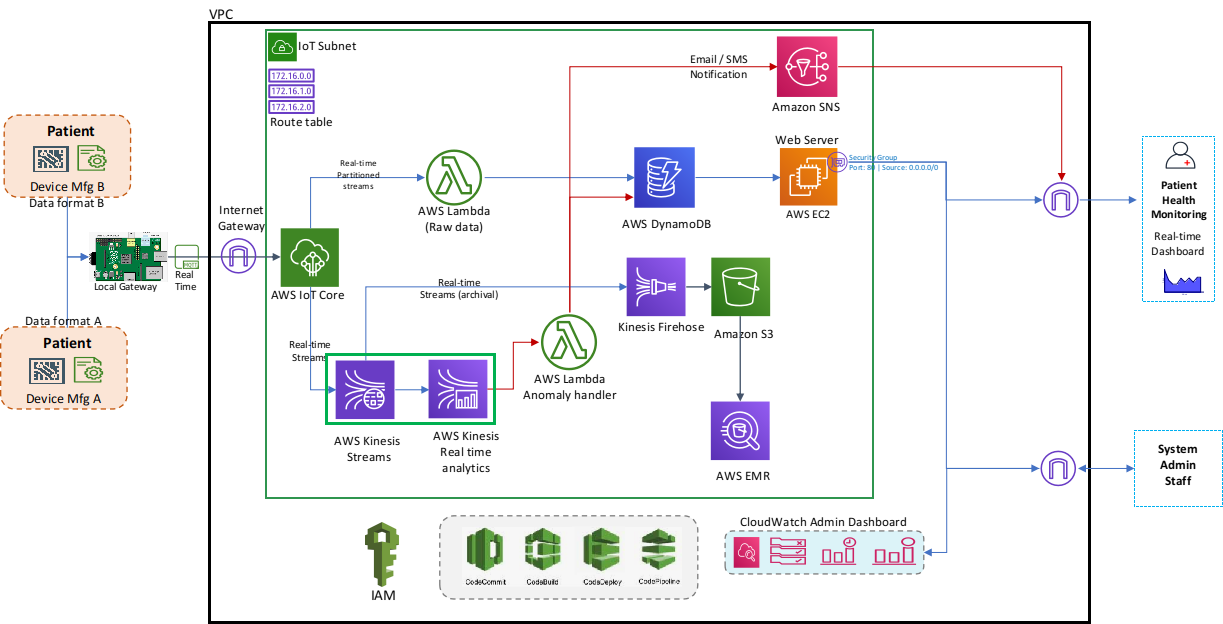

# <font color='blue'> Pre-requisite </font>

In this lab, we are going to build a typical 3-tier application, containerize and deploy it in AWS.

The aim is to have hands-on experience with Docker - setup, configuration, networking, etc.

The application code is minimal, primarily to show a real use case based on the health data.

We are going to need the following software in order to perform this lab:
- Docker (To build and push images)
- aws-cli (To communicate with AWS)

You can do all of these in your AWS Educate account. You can also use a generic AWS account. 

# <font color='blue'> Application Architecture </font>

Below is the high level architecture of the 3-tier application that we are going to build as part of this lab. We have 2 docker containers: one for angular based frontend application and another one for python based REST API application. 

We will be deploying both the containers on EC2 machines within a public subnet and access it through internet facing ALB, so that load can be balanced across multiple containers deployed across multiple EC2 machines. 

We also create EC2 machines in different Availability Zones so that we can support high availability. 

We create an IAM role with access to Elastic Container Registry (ECR) and DynamoDB. And attach this role to EC2 machine so that our Backend container can pull container image from ECR and access DynamoDB to fetch data.


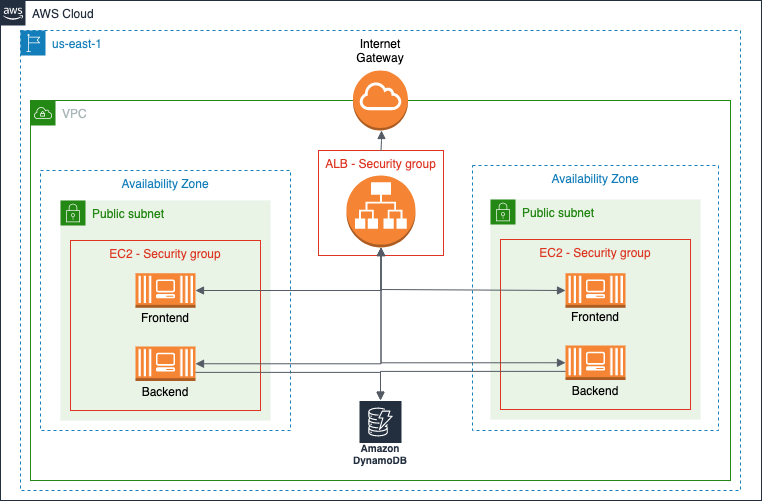

## <font color='blue'> ECR - Create Repository </font>

In this section, We are going to create a respository in Elastic Container Registry (ECR). This is going to be a private repository.

1. Go to ECR or Elastic Container Registry, click on the left pane to expand and then click on Repositories.

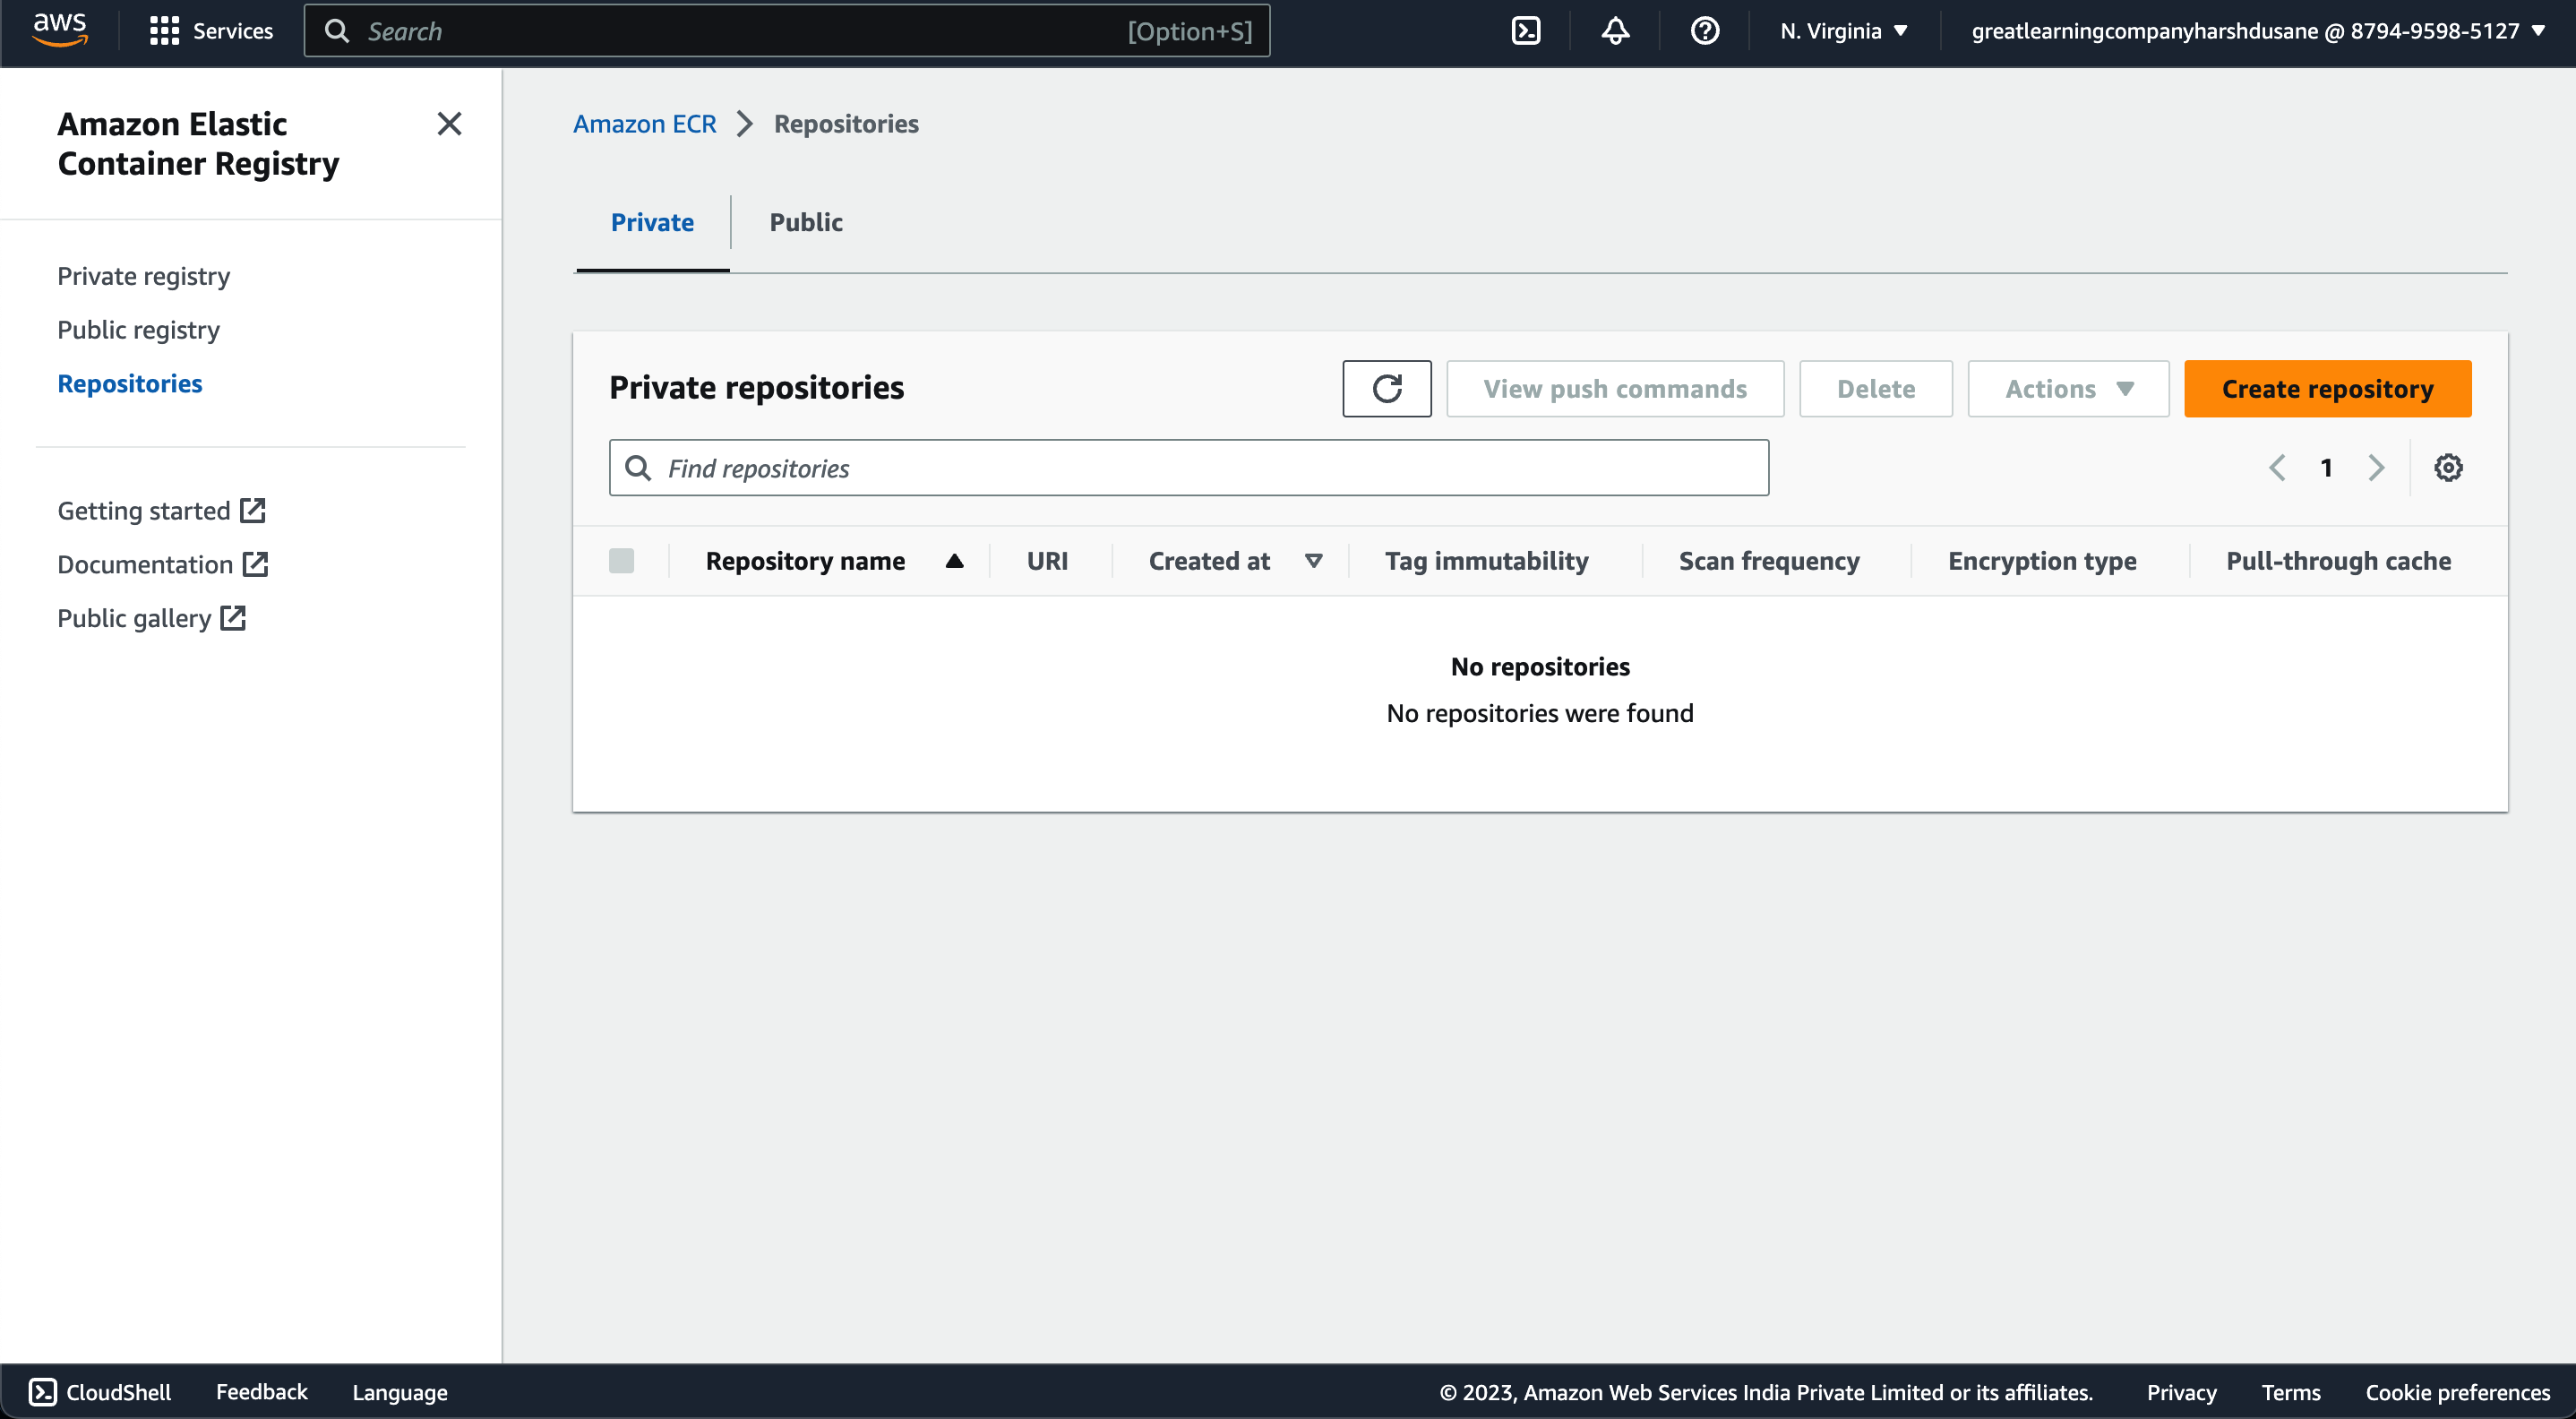

2. Click on Create Repository button. Keep visibility settings to Private. Enter the respository name as `healthcare/service` and you can ignore everything else. Click on Create Repository button at the bottom of the page. This repository will hold container images of our backend application.



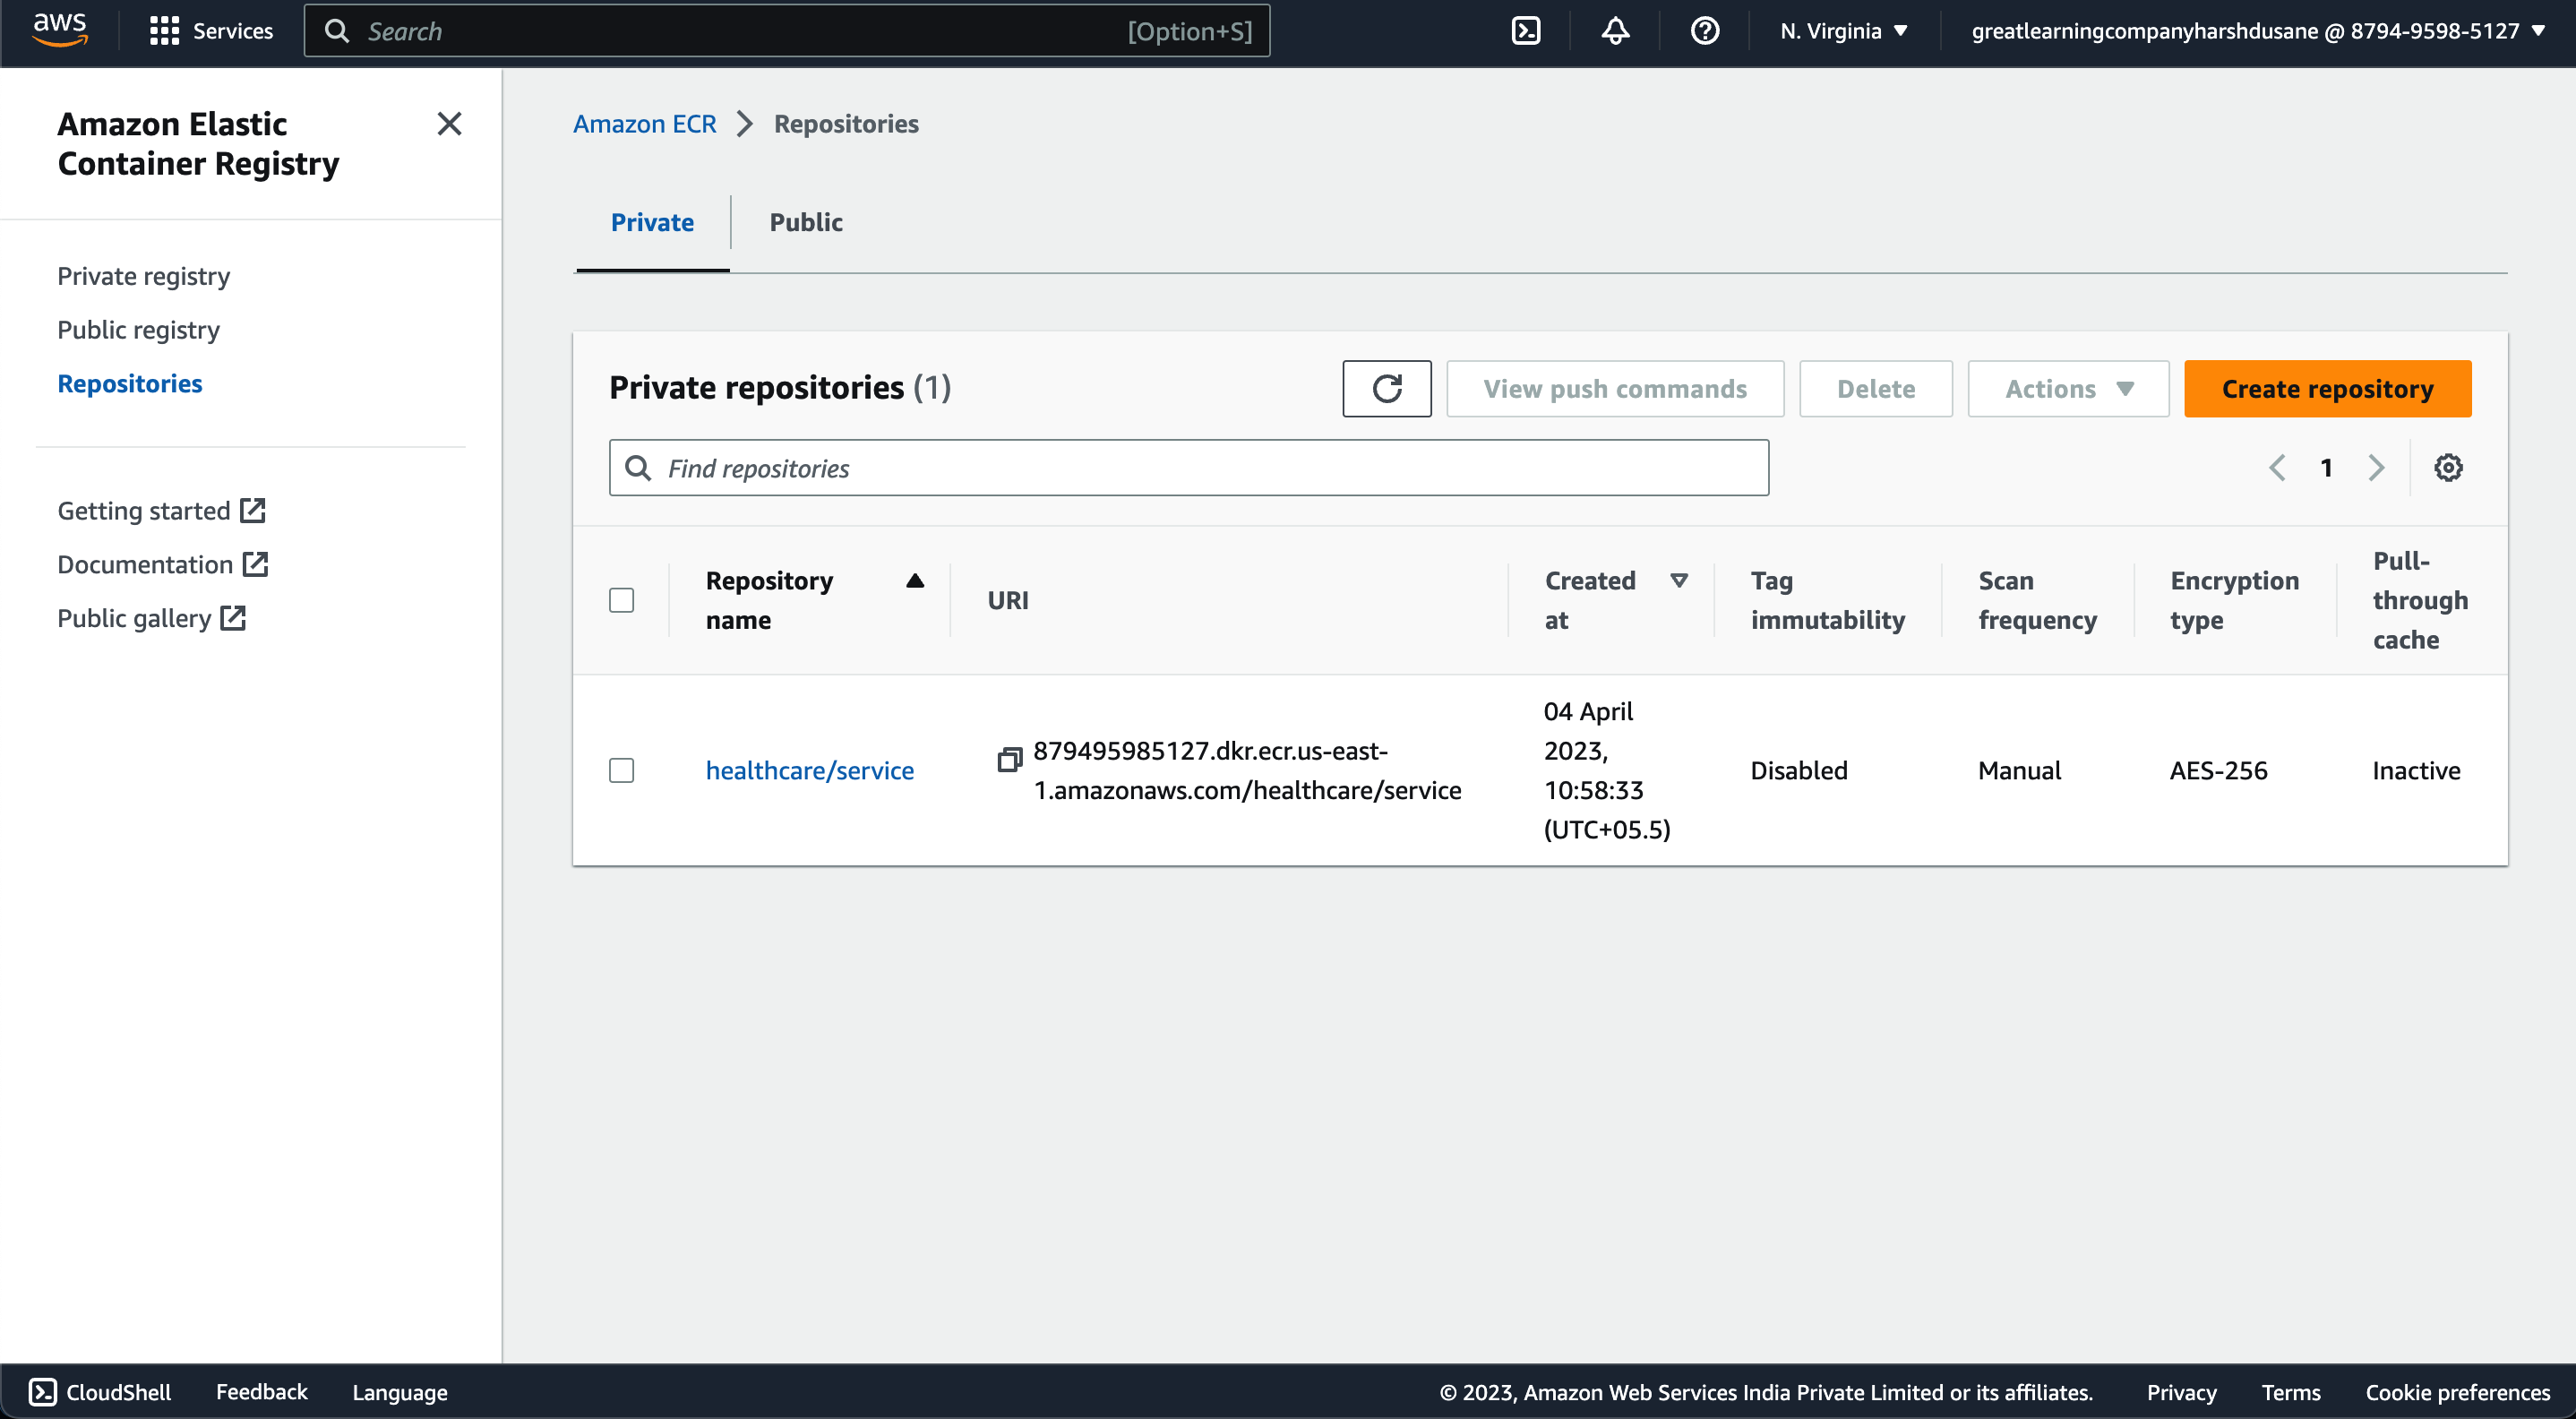

3. Click on Create Repository button again. Enter the respository name as `healthcare/frontend` and then click on Create Repository button again. This respository will hold container images of our frontend application. We should have two repositories created as shown below.

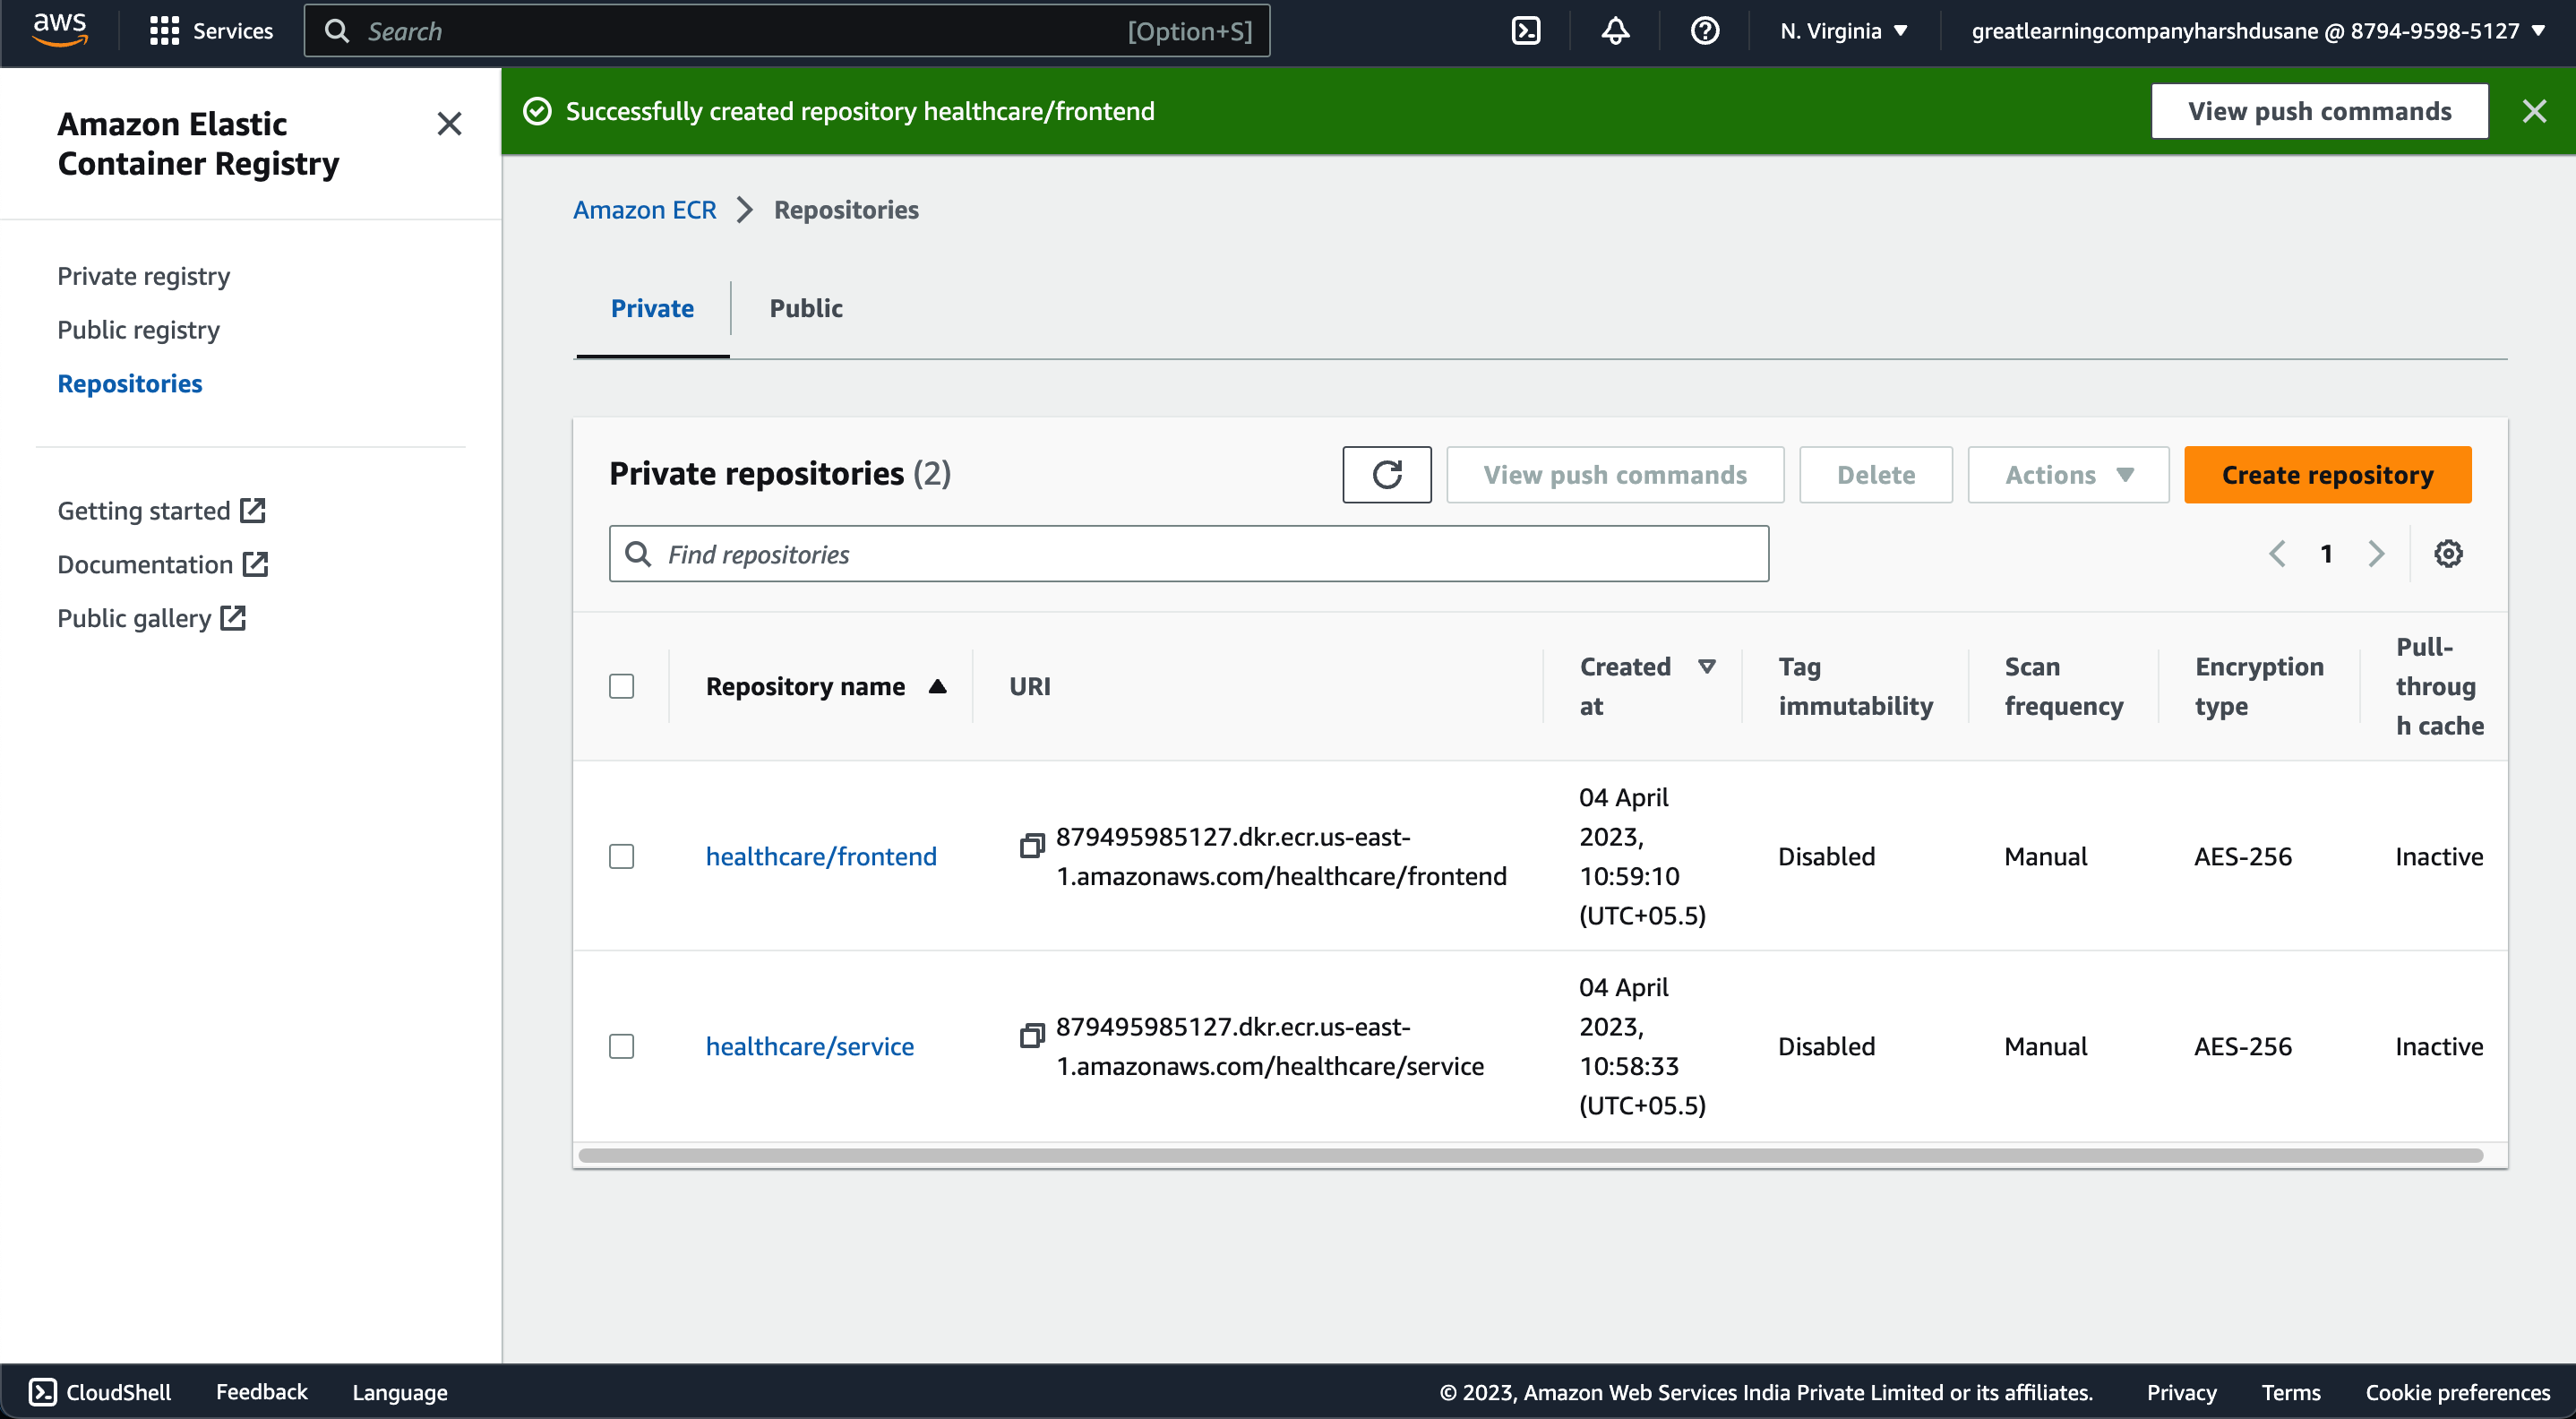

## <font color='blue'> Create IAM Role </font>

In this section, We are going to create an IAM role that we are going to attach to the EC2 instance that we will be launching in the next step.

1. Go to IAM and click on `Create role` button.

2. Select `AWS Service` as the type of trusted entity and select `EC2` as the use case. And click on `Next Permissions` button.

3. In the next page, search for `ec2containerregistry`. Now select `AmazonEC2ContainerRegistryPowerUser` from the search result. This is needed for our EC2 to fetch Docker images from the respository that we just created in the previous step.

4. We need to add another policy to the role. Search for `dynamodb` and select `AmazonDynamoDBFullAccess`. This is needed for our Backend Docker Container within EC2 to communicate to DynamoDB.

5. We need to add another policy to pull source code from S3 bucket. Search for `s3` and select `AmazonS3FullAccess`. Click on Next:Tags and Next:Review.

5. You can enter the name as `EC2HealthCareServiceRole` and enter an apt description. Once done, you should be able to see the created role as below

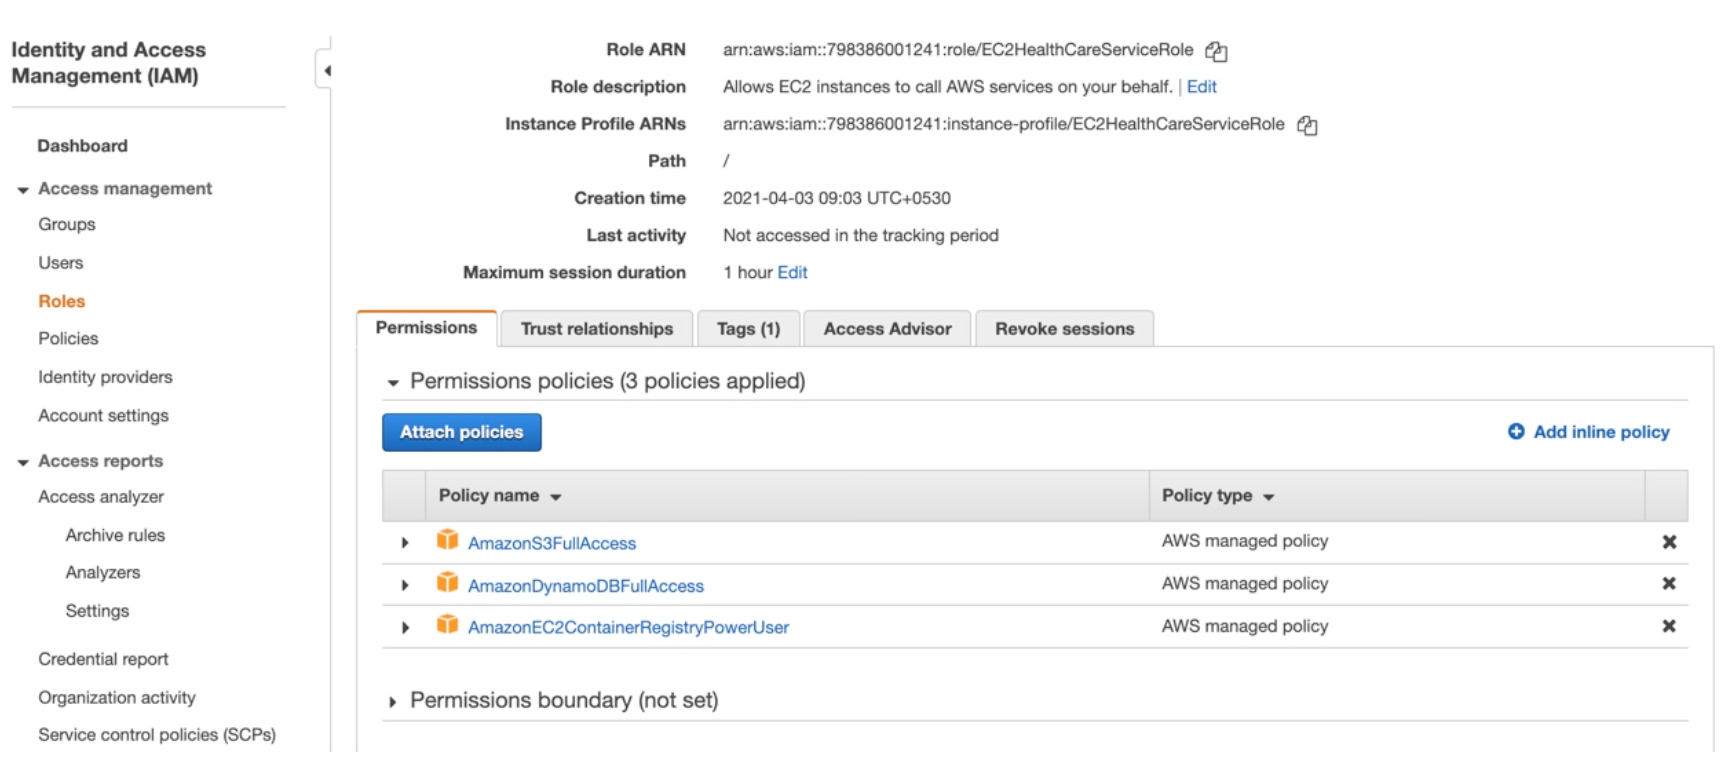

## <font color='blue'> Healthcare Service </font>

### <font color='blue'> Code Walkthrough </font>

This is a very basic REST API developed using Flask. Raw-data end point takes in device id and timeframe as input parameter. This API uses boto3 to connect to DynamoDB and fetches the data based on the parameters passed. At the end, it returns the data as json. Requirement.txt file lists all the dependencies needed to run this application. Most important part is the Dockerfile. Let's review it line by line.

<code>FROM ubuntu:latest

RUN echo Updating existing packages, installing and upgrading python and pip.
RUN apt-get update -y
RUN apt-get install -y python3-pip python3-dev build-essential
RUN pip3 install --upgrade pip</code>

With above commands, it takes ubuntu latest image from Docker repo, update existing packages using apt-get, install and upgrade python and pip.

<code>RUN echo Copying the Healthcare Flask service into a service directory.
COPY ./service /HealthcareService
WORKDIR /HealthcareService</code>

With above commands, we are copying everything under service into HealthcareService folder within Docker and sets the working directory to the same.

RUN echo Installing Python packages listed in requirements.txt
RUN pip3 install -r ./requirements.txt

With above commands, we are installing Python packages listed in requirements.txt file

<code>RUN echo Starting python and starting the Flask service...
ENTRYPOINT ["python3"]
CMD ["healthcareService.py"]</code>

With above commands, we are setting entypoint to Python3 and executing a command to start Flask service.


### <font color='blue'> Launch EC2 Instances </font>

1. In this section, let's go ahead and launch the EC2 instance. Click on Instances and then click on `Launch Instances`.

2. Select `Amazon Linux 2 AMI (HVM), SSD Volume Type' with 64-bit x86 and then click on Select button.

3. Select `t2.micro` as the instance type and click on Next button

4. In the `Configure Instance Details` page, enter number of instances as 1. We are going to create another instance again in a different AZ in order to demonstrate Load Balancing feature. You can select the default VPC with public subnet in any AZ.

5. Click on `Next: Add Storage` button. We are good with default root volume for our applications. Click on `Next: Add Tags` button. Click on `Next: Configure Secuirty Group` button.

6. Create a new Security Group with name as `HealthcareEC2SG` and with inbound rule for SSH and provide a name & a description. You can select source as `My IP` so that is more restricted. This is needed in order to SSH into this EC2 machine.

7. Click on `Review and Launch` button. And then review the details once, click on `Launch` button. Make sure to attach an existing key pair or create a new key pair so that we will be able to SSH into this EC2.

8. Repeat the above steps and launch another EC2 instance. Make sure to select another subnet in a different AZ so that our application will be highly available.

9. Once the EC2 instances are launched, You should be able to see those in Instances page under EC2. You can provide a friendly name to your instances to identify them.

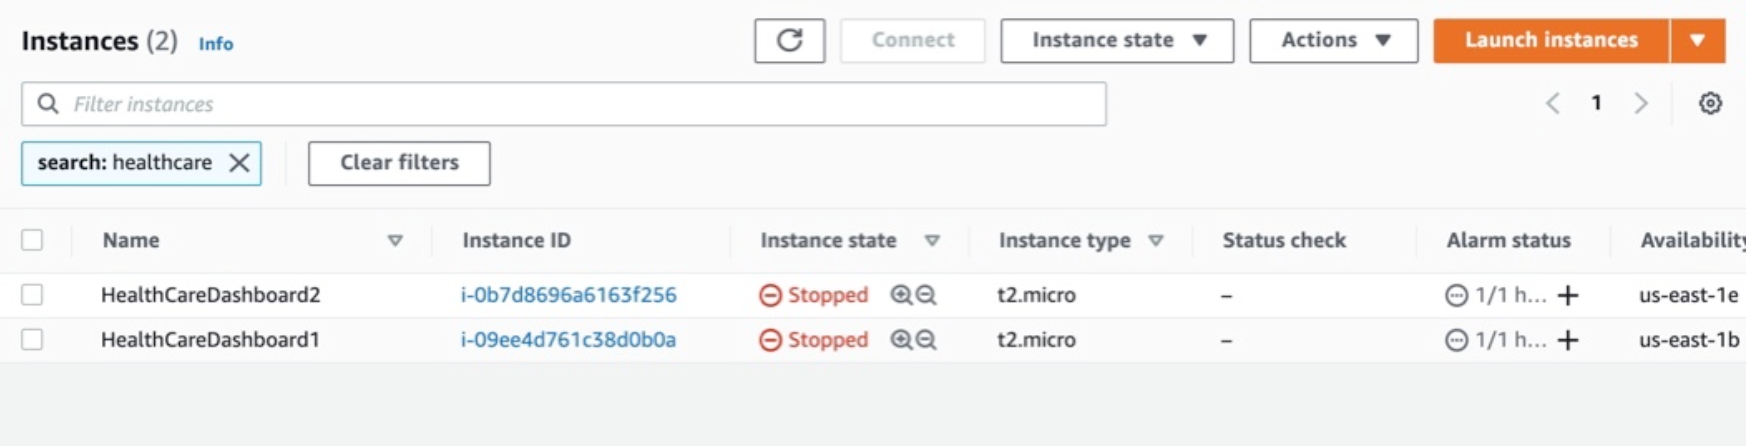

10. Let's go ahead and attach the IAM role that we created in the previous step. Select EC2 instance -> click on `Actions` button on the top right corner -> Click on Security -> Click on Modify IAM role. Select the `EC2HealthCareServiceRole` from the dropdown and click on Save. Repeat this step for both EC2 instance.

### <font color='blue'> Install Docker and copy source code</font>

1. We can SSH into this EC2 machine now and install Docker since it does not come installed with the AMI we used. You can use either putty or any other SSH client to connect to this EC2 machine and then issue the below commands. First command is to update all the package using yum. Second command is to install Docker. Third command is to start Docker. Fourth command is to add ec-user to docker group so that we dont have to use sudo while using docker command hereafter.

<code> sudo yum update -y </code>

<code> sudo amazon-linux-extras install docker </code>

<code> sudo service docker start </code>

<code> sudo usermod -a -G docker ec2-user </code>

2. Once the above commands are executed, exit and ssh once again to have the effect of fourth command from previos step. 

3. Let's go ahead and copy the source code from S3 bucket into EC2 machine. And then we will extract the zip file for Backend Service. Enter the below commands while replacing your S3 bucket name.

<code>aws s3 cp (S3BucketName) BackendApp.zip
unzip BackendApp.zip</code>

### <font color='blue'> Docker Build & Push </font>

In this section, We are going to see step by step guidance for building an image of `Healthcare Service` using Docker and push the Docker image to ECR. We need to do this step only on one EC2 machine.

1. Go to Terminal and navigate to `BackendApp` folder.

2. Enter the below command. Replace the (awsaccountid) with your own aws account id

<code> docker build . -t (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/service:latest </code>

3. With the above code, We are issuing a command to Docker daemon to build a container image with a tag name that is specified after -t. This is needed in order to push this image to the repository that we created above. If the command is successful, we should be able to see the container image created using the below command.

<code> docker image ls </code>

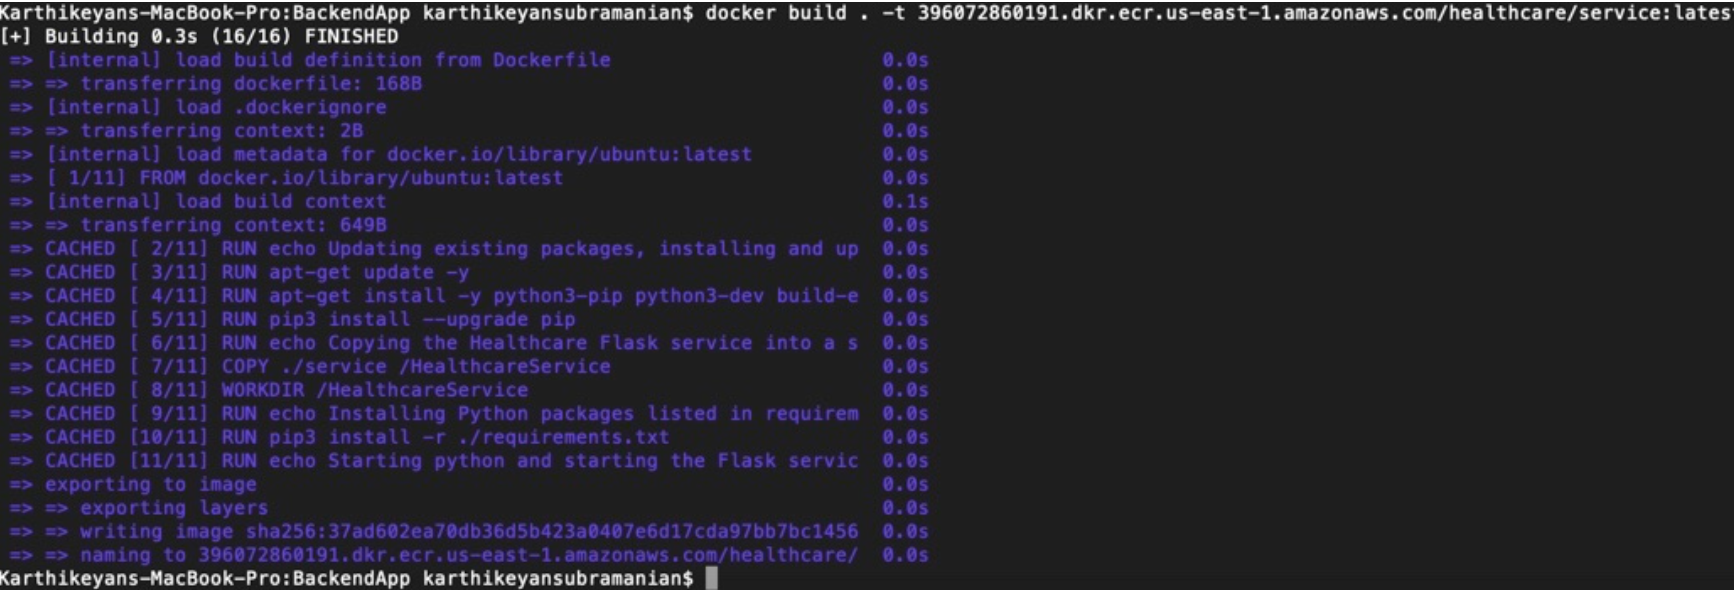

4. We built the docker image for backend application in the previous step. Let's go ahead and push this docker image to ECR so that we can pull it from EC2 machine. Use the below command to login with your Docker client. Replace the (awsaccountid) with your own aws account id. After you run the commands, you can go to ECR and check the repos. You should have one container image in the healthcare/service repo with latest as the tag as shown in the screenshot below.

<code>aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin (awsaccountid).dkr.ecr.us-east-1.amazonaws.com<code>

<code> docker push (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/service:latest </code>

<code> docker pull (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/service:latest </code>

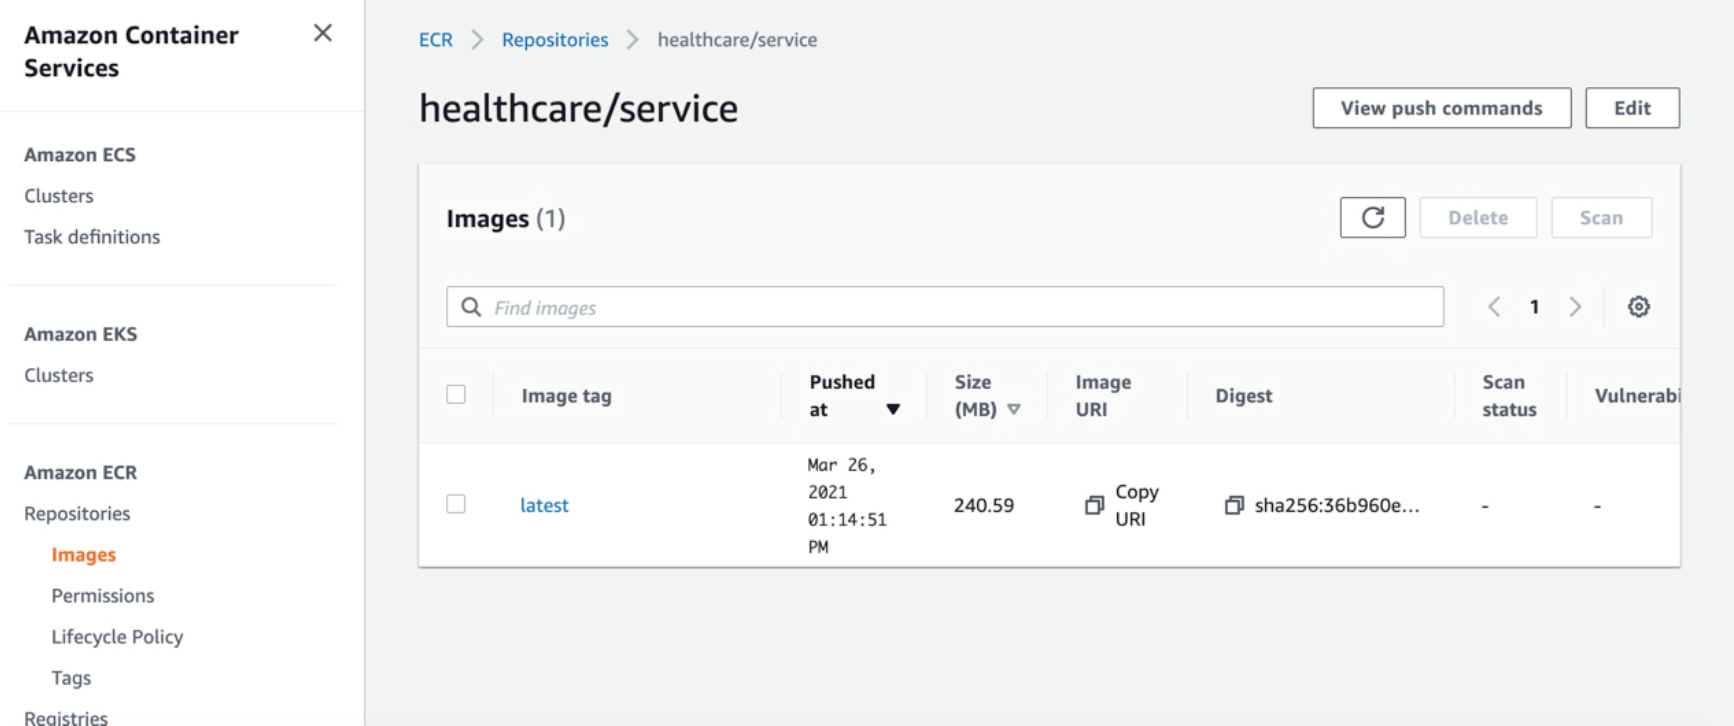

### <font color='blue'> Docker Pull </font>

1. Since we pushed the Docker image, let's pull it from ECR now on both EC2 machines. Below are the commands for that. First command is to get an auth token for the Docker client. This uses EC2 metadata service to find the IAM role associated with this EC2 machine. Second command is to pull the Docker image from ECR.

<code> aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin (awsaccountid).dkr.ecr.us-east-1.amazonaws.com </code>

<code> docker pull (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/service:latest </code>

2. After the Docker image is pulled, you should be able to see the image by using the below command

<code> docker image ls </code>

3. Let's go ahead and run the Docker container using the below command. Please note that we are running the application on port 8080 within a container and port mapping of 8080 on the host as well.

<code> docker run -d -p 8080:8080 (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/service:latest </code>

5. Please repeat the above steps for another EC2 instance.

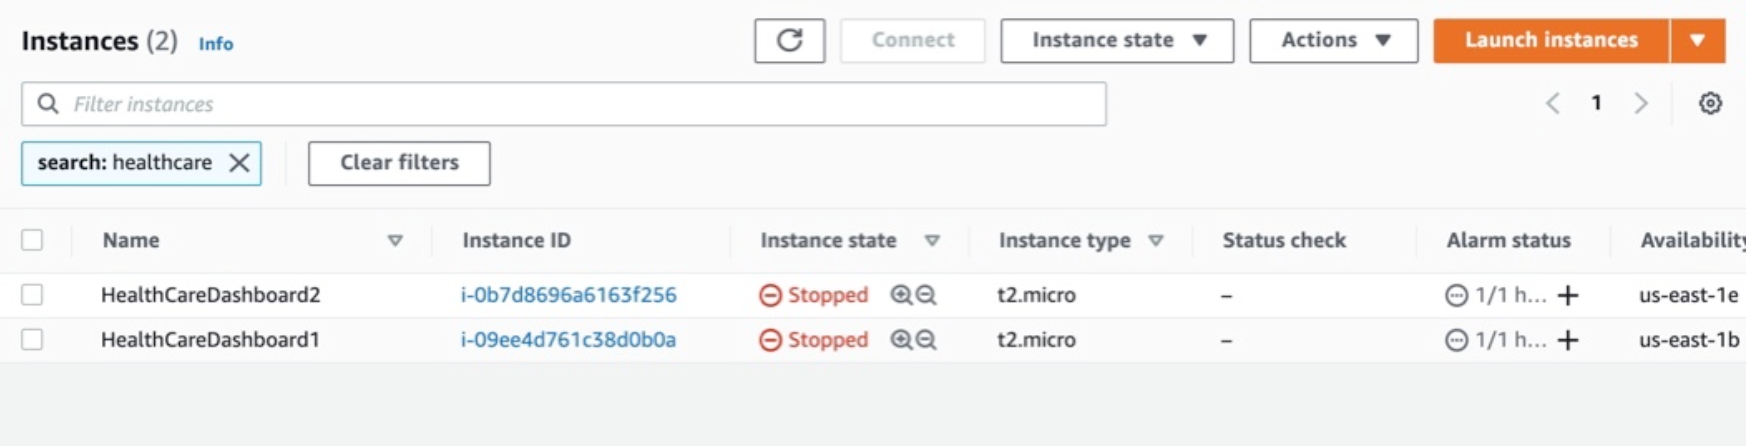

# <font color='blue'> ALB for Healthcare Service </font>

We have deployed the Healthcare Service Docker Containers in two EC2 machines. Now we should create our ALB in order to enable incoming traffc and also load balance the traffic. 

Please follow the below mentioned steps to create ALB.

1. Go to Load Balancers section in EC2 and click on `Create Load Balancer`.

2. Click on Create button in `Application Load Balancer`. Give the name as `HealthcareDashboardALB`. Schema should be internet-facing. Leave ip address type as ipv4. Listeners should have HTTP with port 80. In AZ section, select the subnets in which your EC2 were launched. Click on Next button.

3. Ignore the error in the next page. We are using HTTP listener. In Production, we would be using HTTPS with certificates installed. Click on Next to continue.

4. Create a new Security Group with a name as `HealthcareALBSG`. Allow incoming traffic on HTTP with port 80 from everywhere (0.0.0.0/0, ::/0) as source. Click on Next.

5. Create a new Target group with name `HealthcareServiceTG`. Keep the target type as Instance, protocol as HTTP and port as 8080. The port is 8080 since our container is running on that port. Click on Next button.

6. In the next page, select the two EC2 machines and click on `Add to registered` button. Click on Next button. Review the details and click on Create button.

7. Once created, you should be able to see the ALB and Target Group as below.

ALB (Application Load Balancer):

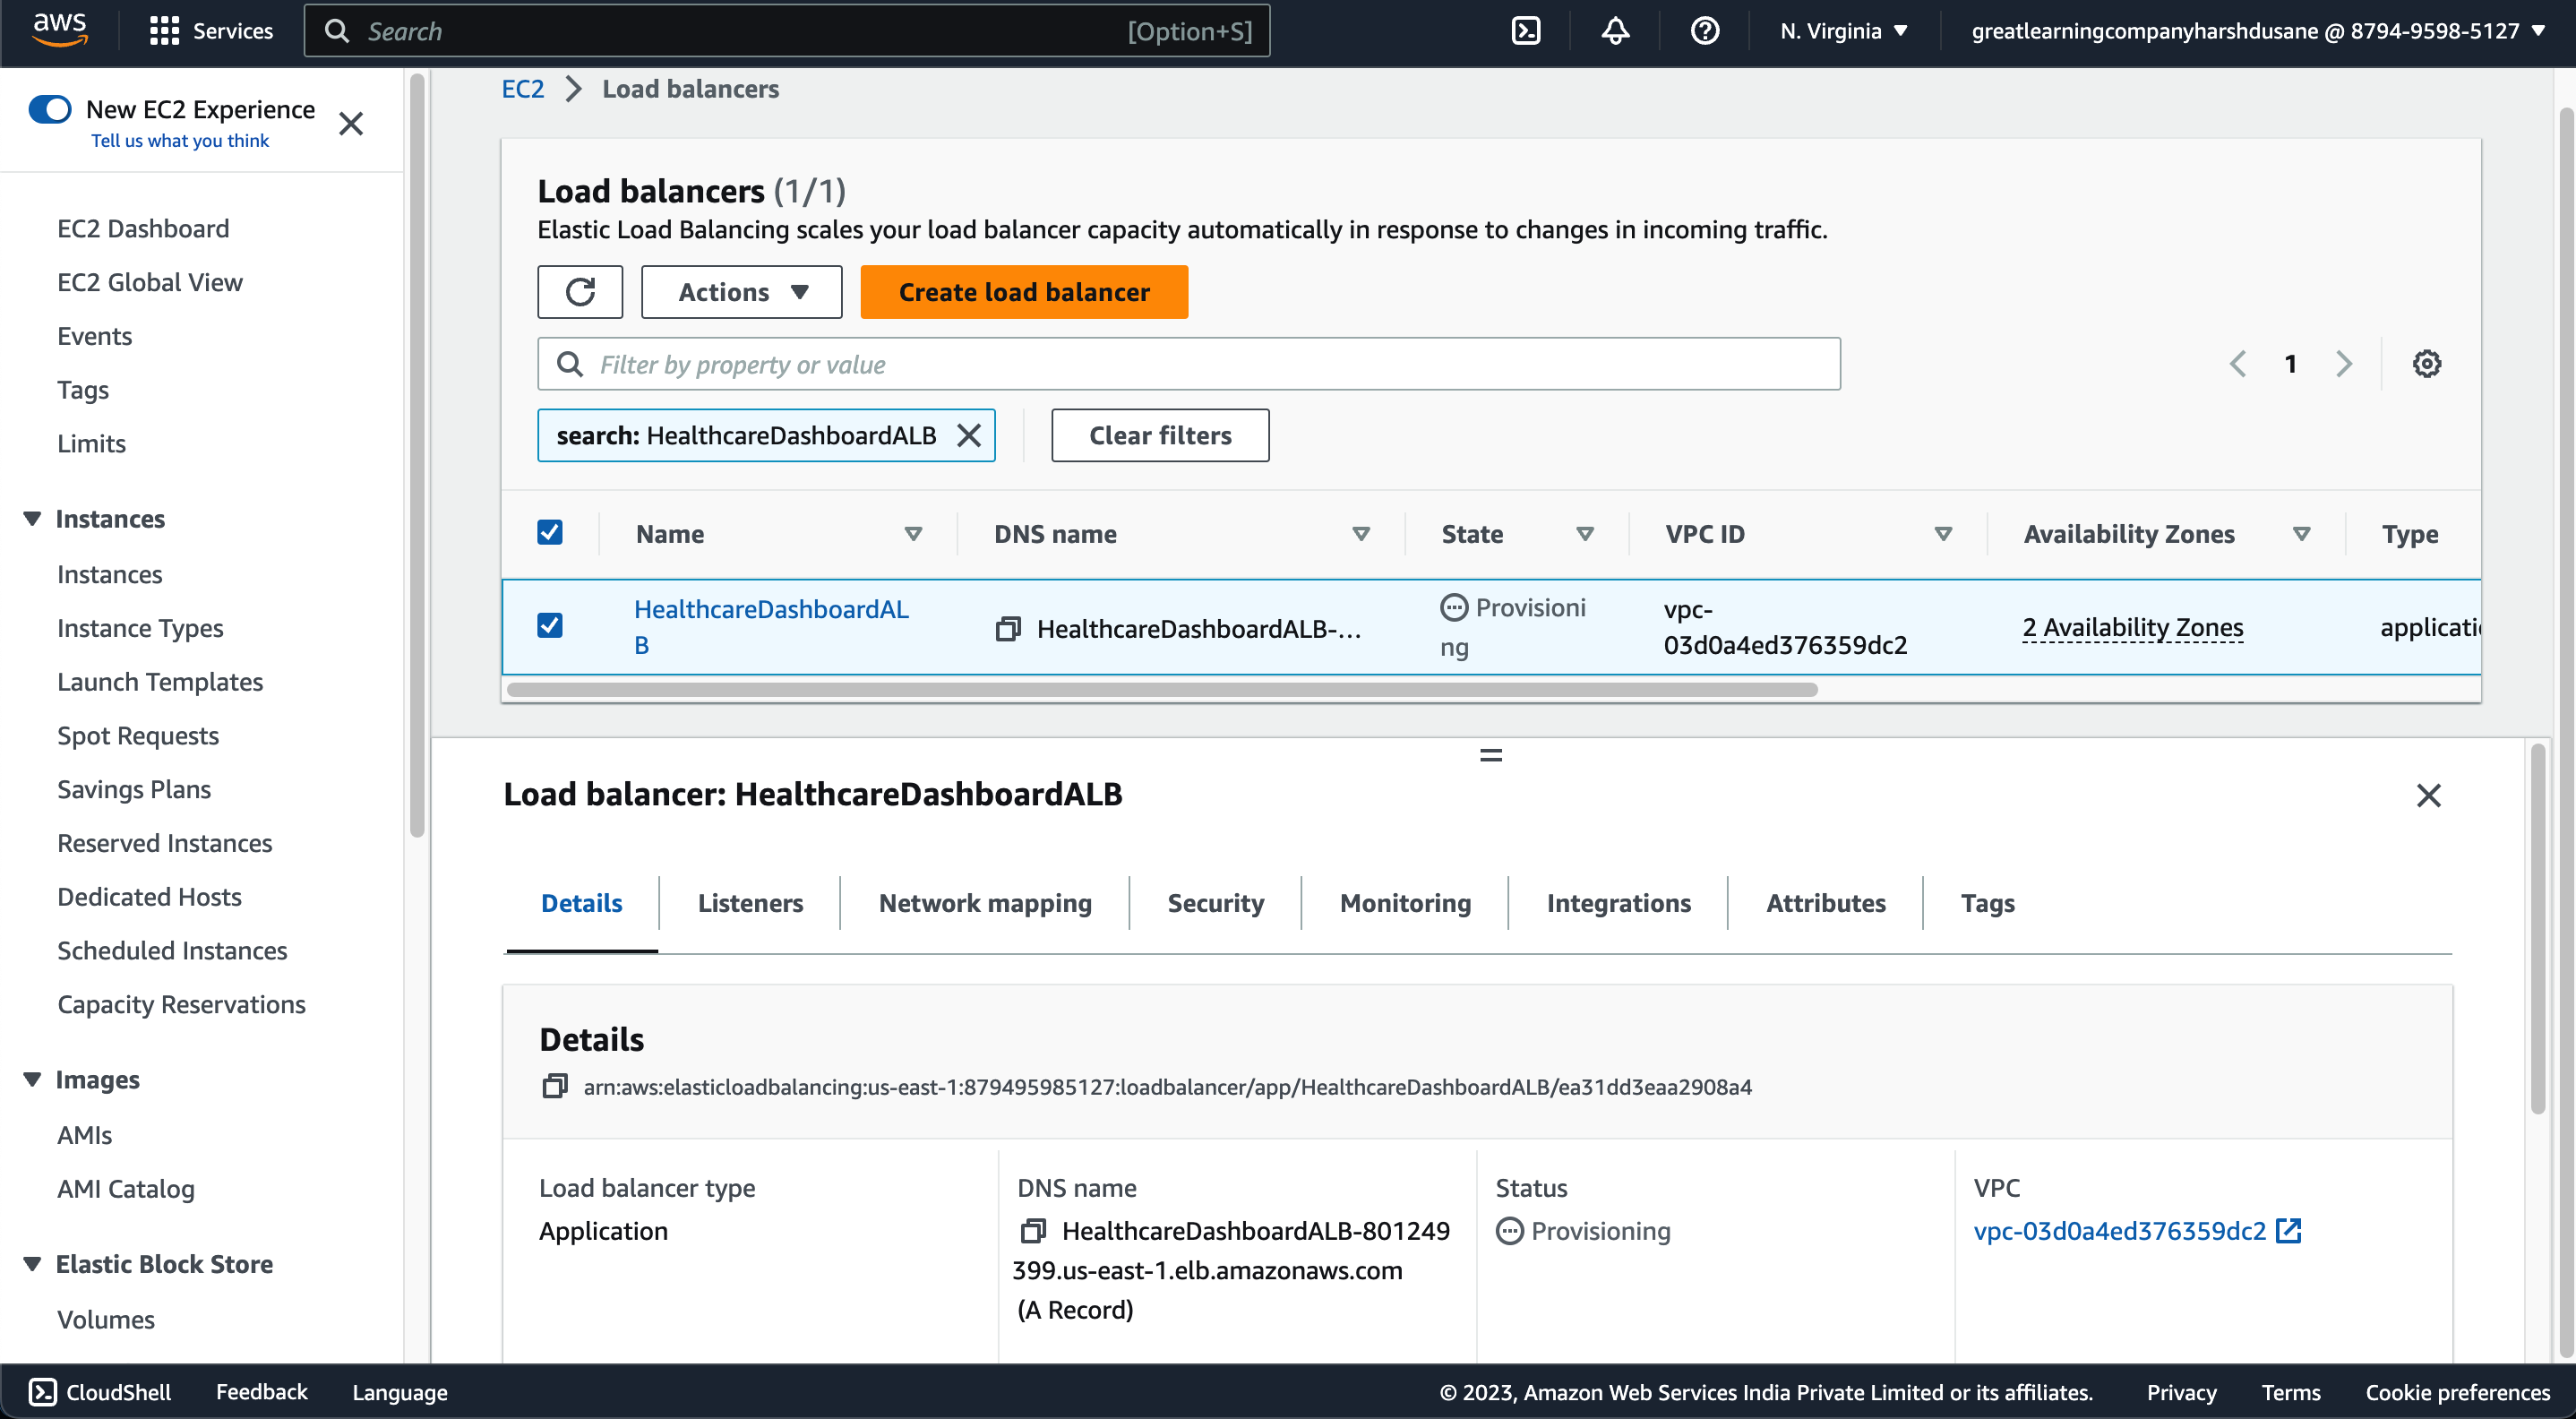

Target Group:

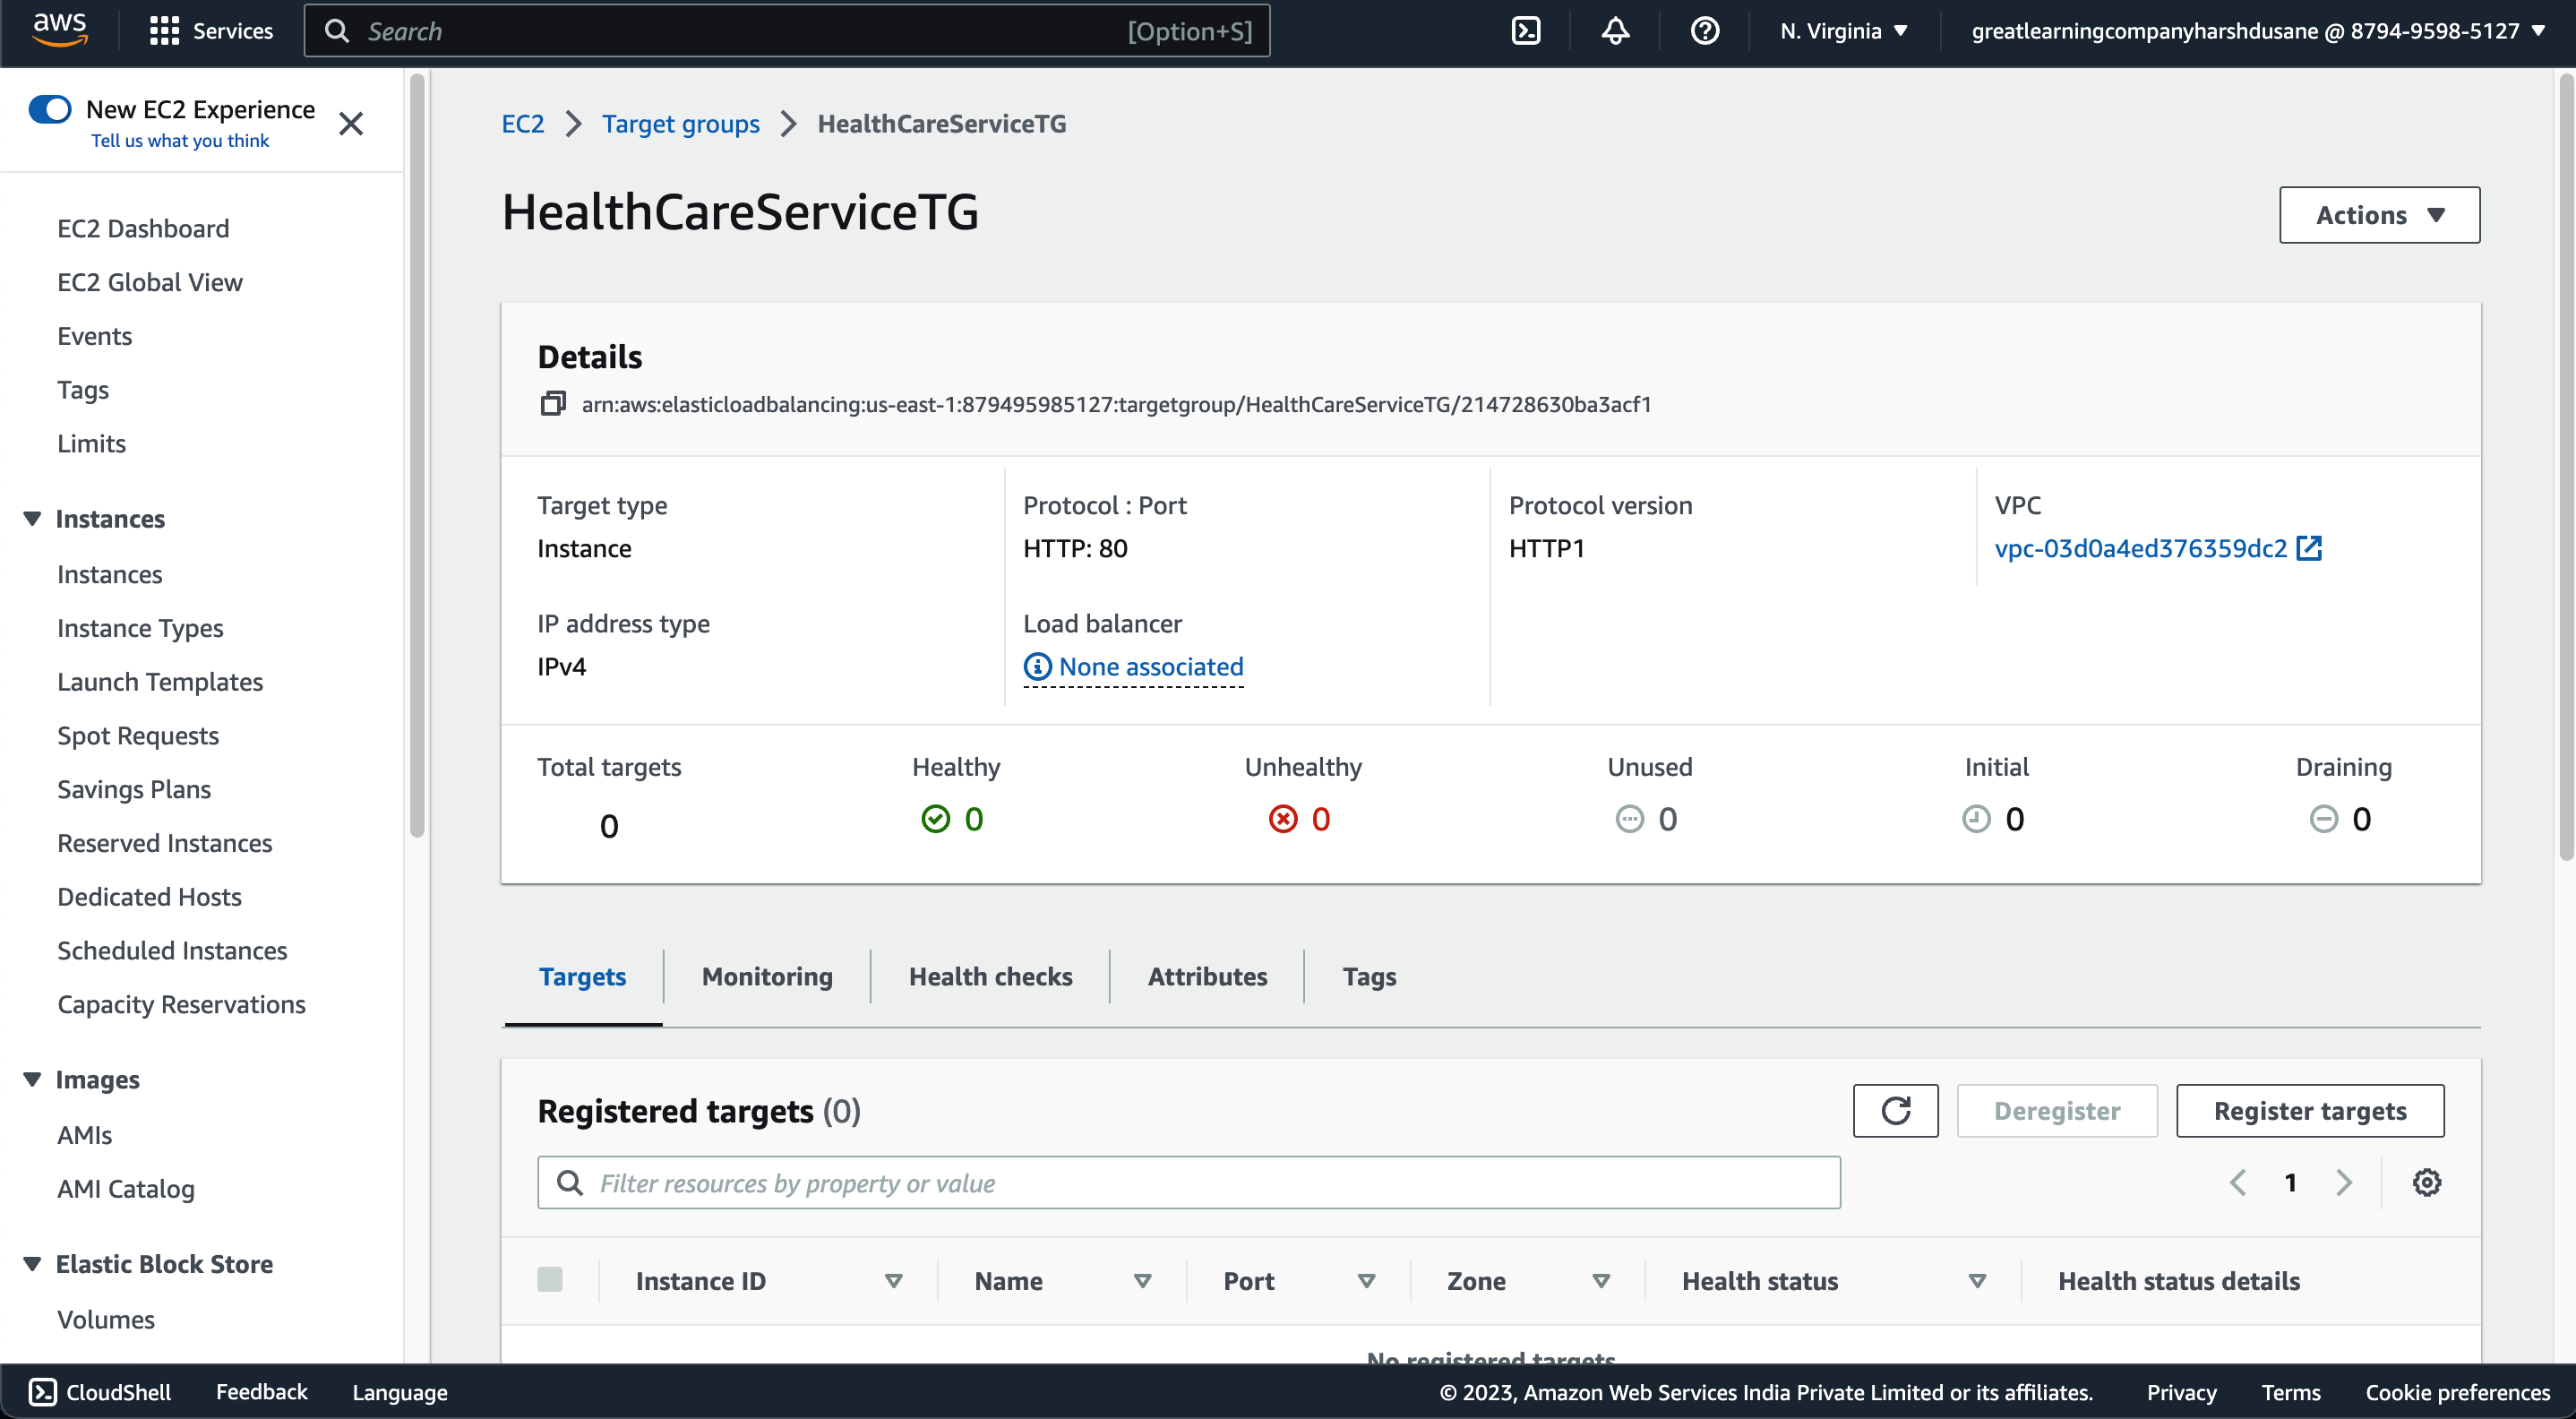

8. Once the ALB is in active state, you can go to EC2 and go to the Security Group attached to the EC2. And add inbound rule to allow Custom TCP with port 8080 from the security group of ALB that we created. Name of that Security Group should be `HealthcareALBSG`. This is needed to allow traffic on port 8080 from ALB.

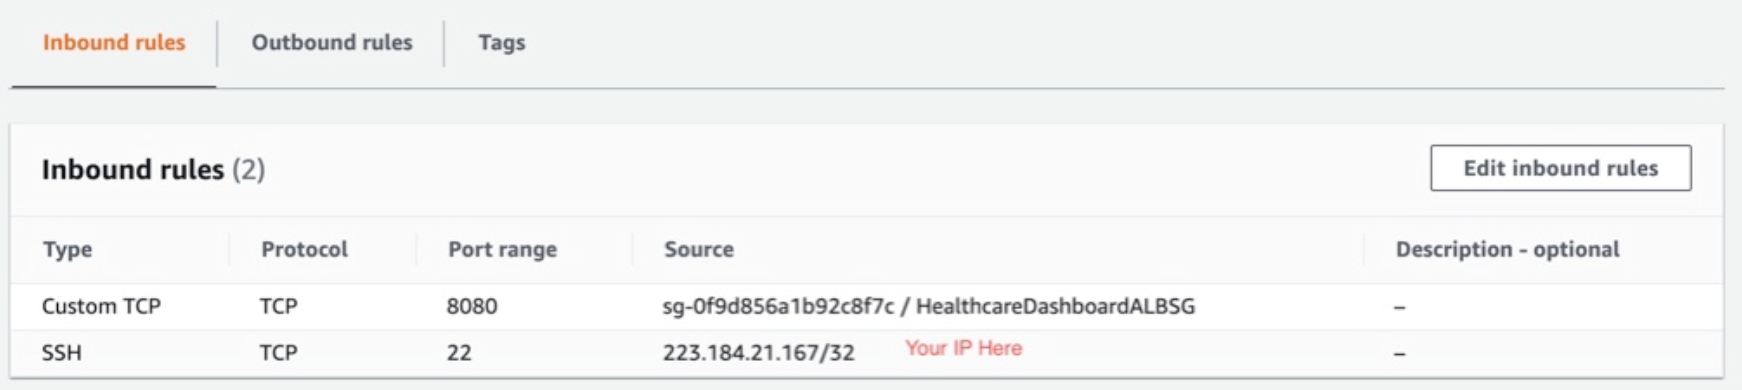

9. Now, we should be able to access the API from internet through our ALB that we created. Find the public DNS of the ALB and substitute it in the below URL, replace DeviceId, StartDate and EndDate according to the data available in DynamoDB. Hit the URL from a browser and you should get a json response.

<code> http://(public DNS)/api/raw-data?deviceid=(DevideID)&startdate=(StartDate)&enddate=(EndDate) </code>

## <font color='blue'> Healthcare Frontend </font>

### <font color='blue'> Code Walkthrough </font>

This is a very basic Angular 7 application created using angular-cli. It has 2 pages: one for raw-data and another page for showing anamolies. Both of these pages make a HTTP call to our Backend Service to fetch the data from DynamoDB. HTTP calls to Backend Service are made from `healthcare-data.service.ts` file. We are using nginx to serve this staic content. Most important part is the Dockerfile. We are using multi stage build here.

<code>### STAGE 1: Build ###
FROM node:12.7-alpine AS build
WORKDIR /usr/src/app
COPY package.json package-lock.json ./
RUN npm install
COPY . .
RUN npm run build</code>

1. ( FROM) getting node Docker base image from repo and naming the compilation stage as build (so we will be able to refer to it in another stage)

2. ( WORKDIR ) setting default working directory

3. ( COPY ) copying package.json & package-lock.json files from local root directory — this file contains all dependencies that our app requires

4. ( RUN ) installing necessary libraries (based on a file copied in previous step)

5. ( COPY ) copying all remaining files with source code

6. ( RUN ) and finally compiling our app

<code>### STAGE 2: Run ###
FROM nginx:1.17.1-alpine
COPY nginx.conf /etc/nginx/nginx.conf
COPY --from=build /usr/src/app/dist/healthcare-app /usr/share/nginx/html</code>

1. Get the nginx Docker base image from Docker Hub tagged with 1.17.1-alpine

2. Copy the default nginx configuration defined in nginx.conf file

3. Finally copy the compiled application to the container. Please note --from=build, this refers to the files from previous stage.

### <font color='blue'> Docker Build & Push </font>

In this section, We are going to see step by step guidance for copying source code for frontend app from S3, extract the zip, build an image of `Healthcare Frontend` using Docker and pushing the Docker image to ECR. 
1. Let's go ahead and copy the frontend app source code from S3 bucket into EC2 machine. And then we will extract the zip file for Frontend application. Enter the below commands while replacing your S3 bucket name.

<code>aws s3 cp (S3BucketName) FrontEndApp.zip
unzip FrontEndApp.zip</code>

2. After extracting, inside src->app>service folder of the `FrontEndApp`, we need to modify the file `healthcare-data.service.ts` file. Please copy the public DNS of the ALB that we created in one of the previous steps and replace it in the `healthCareServiceURL` variable. This is needed in order to access the Backend Service that we created earlier through the ALB.

<code>private healthcareServiceURL = 'http://(ALBPublicDNS)/api/raw-data?';</code>

2. Go to Terminal and navigate to `FrontEndApp` folder.

2. Enter the below command. Replace the (awsaccountid) with your own aws account id

<code> docker build . -t (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/frontend:latest </code>

3. With the above code, We are issuing a command to Docker daemon to build a container image with a tag name that is specified after -t. This is needed in order to push this image to the repository that we created above. If the command is successful, we should be able to see the container image created using the below command.

<code> docker image ls </code>

4. We built the docker image for frontend application in the previous step. Let's go ahead and push this docker image to ECR so that we can pull it from EC2 machine. Use the below command to login with your Docker client. Replace the (awsaccountid) with your own aws account id. After you run the commands, you can go to ECR and check the repos. You should have one container image in the healthcare/frontend repo with latest as the tag.

<code> aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin (awsaccountid).dkr.ecr.us-east-1.amazonaws.com </code>
    
<code> docker push (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/frontend:latest </code>

### <font color='blue'> Docker Pull </font>

1. Let's pull the Docker image in EC2 from ECR now. Below are the commands for that. First command is used to get an auth token for the Docker client. This uses EC2 metadata service to find the IAM role associated with this EC2 machine. Second command is to pull the Docker image from ECR.

<code> aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin (awsaccountid).dkr.ecr.us-east-1.amazonaws.com </code>

<code> docker pull (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/frontend:latest </code>

2. After the Docker image is pulled, you should be able to see the image by using the below command

<code> docker image ls </code>

3. Let's go ahead and run the Docker container using the below command. Please note that we are running the application on port 80 within a container and a port mapping of 8888 on the host.

<code>docker run -d -p 80:80 (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/frontend:latest</code>

5. Please repeat the above steps for another EC2 instance.

# <font color='blue'> ALB for Healthcare Frontend </font>

We have deployed the Healthcare Service Docker Containers in two EC2 machines. Now we should be able to edit the rules of the existing ALB to allow traffic to the Frontend containers.

1. Let's create a Target Group to use for our frontend application. Go to Target groups in EC2 and click on `Create Target groups`.

2. Choose Instances as the target type. Give name as `HealthcareFrontEndTG`. You can leave protocol as HTTP and port as 80. Leave everything else to default value. Click on next.

3. In the next page, select the two EC2 instances that we have and register them as targets in pending state. And then you can click on create button.

4. Now go to Load Balancers section in EC2 and select the ALB that we created in the previous step.

2. Click on the Listeners tab and click on View/edit rules for the HTTP listener.

3. We are going to enable path based routing in the ALB for both backend and frontend containers. When the path is `/api/*` then we route it to backend service by forwarding the request to `HealthcareServiceTG`, otherwise forward the request to `HealthcareFrontEndTG` that we created above. Click on the add and edit button on this page to make these changes. Once done, it should look like below. Save the changes.

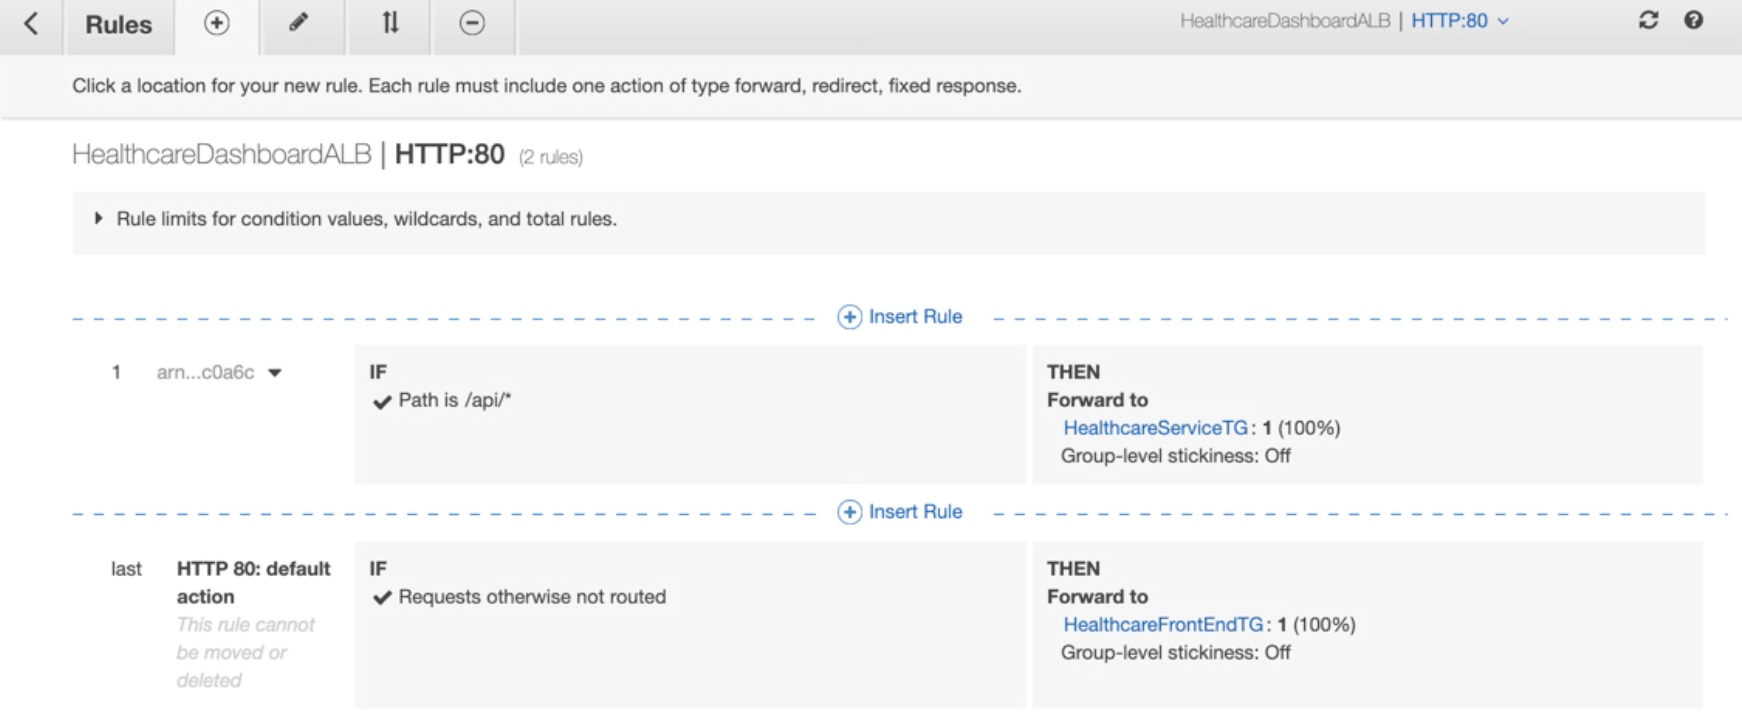

4. Once that is done, we need to enable inbound traffic with HTTP and port 80 for our EC2 security group. This in bound rule should be applied to ALB security group only. You should have 3 inbound rules as shown below.

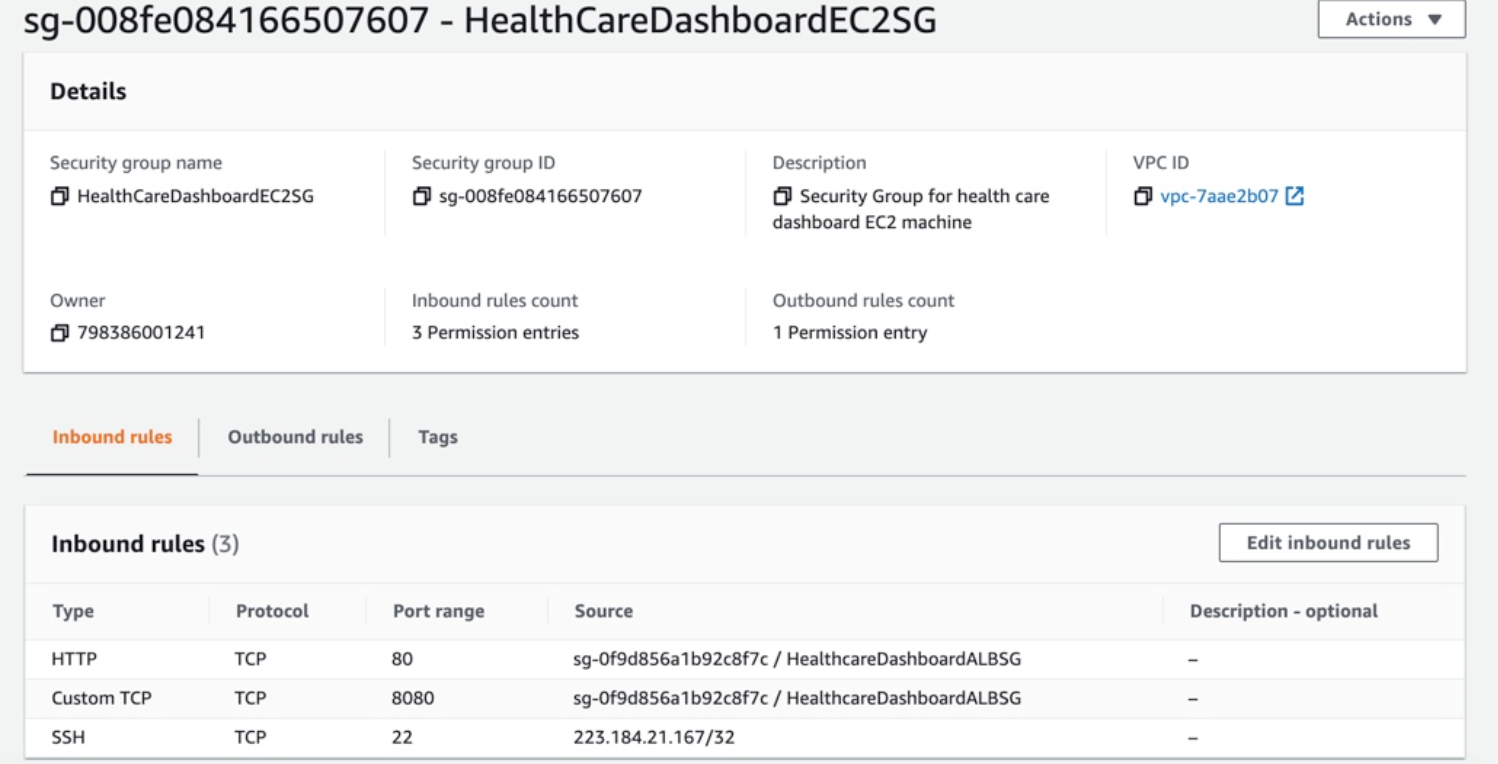

# <font color='blue'> Testing the application</font>

We have everything we need now. We should be able to access the application through the public DNS of our ALB. Please copy the public DNS of our ALB and then enter it in a browser window. We should be able to see the frontend application as below.

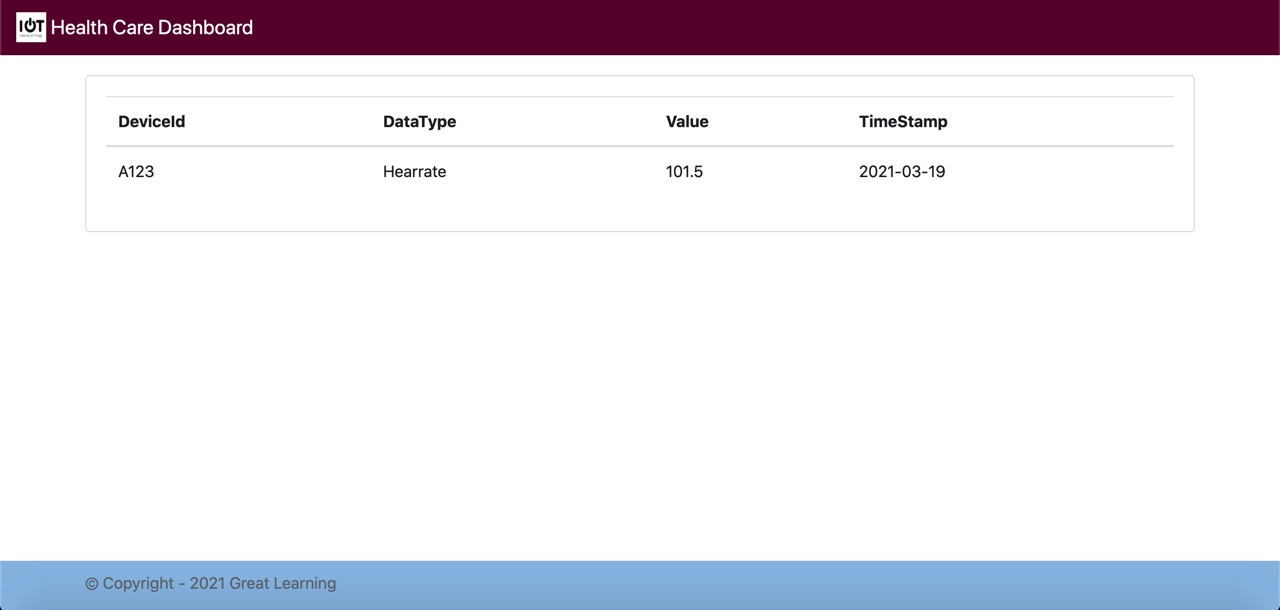

# <font color='blue'> Deploying updates </font>

If we ever want to update this application such as adding another endpoint or adding another page in our Angular application then how do we deploy those changes to the server? Let's discuss about it briefly in this section. 

1. When we make changes to the application, we need to build the docker image again. This can be for frontend or backend or both. I am going to use service as the example here.

Frontend:
<code>docker build . -t (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/frontend:latest</code>

Backend:
<code>docker build . -t (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/service:latest</code>

2. Once the docker images are built, we need to push it to ECR.

<code> aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin (awsaccountid).dkr.ecr.us-east-1.amazonaws.com </code>
    
<code> docker push (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/service:latest </code>

3. Once the docker images are pushed to ECR, we need to pull them in EC2.

<code>aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin (awsaccountid).dkr.ecr.us-east-1.amazonaws.com
docker pull (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/service:latest</code>

4. Once the docker images are pulled into EC2, we need to stop and start the existing containers in order to make the changes effective. Remember, existing containers are still running old images.

<code>docker container ls (copy the container id from the output of this command)
docker stop (containerid copied)
docker run -p 8080:8080 (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/service:latest</code>
    
5. Repeat the above steps for all the containers.

This deployment strategy is called Rolling Update which will reduce the available capacity during deployment. There are other deployment strategies which would not reduce the available capacity but the steps for that would be similar as well.

# <font color='blue'> Scaling the application</font>

Please note that we have 2 containers running for both frontend and backend. This is enough to support some kind of traffic that exists today. But what if the traffic to our website increases and our existing containers are not able to support it? Then all that we need to do is increase the container count and add it to the Target Group. If our existing EC2 machines reached the maximum capacity and we are not able to add any more containers then we need to launch new EC2 instances, deploy containers into those newly launched EC2 instances and add them to our Target Group.

# <font color='blue'>Use case 1 - Micro Services</font>

You can build web applications that run in a highly available configuration across multiple Availability Zones. In addition to EC2 being highly available, we can use RDS or DynamoDB or any other data store that provides high availability by replicating data across multiple AZs. Additionally, your services get out-of-the-box integrations with AWS networking and security services, such as Application Load Balancers for load distribution of your web application and VPC for networking. In addition to the above advantages of AWS services, Docker provides us various advantages.

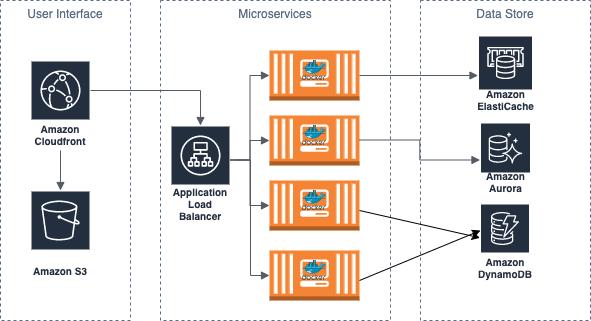

## <font color='blue'> 1. Simplifying Configuration </font>

The primary use case Docker advocates is simplifying configuration. One of the big advantages of VMs is the ability to run any platform with its own config on top of your infrastructure. Docker provides this same capability without the overhead of a virtual machine. It lets you put your environment and configuration into code and deploy it. The same Docker configuration can also be used in a variety of environments. This decouples infrastructure requirements from the application environment. The freedom to run your applications across multiple IaaS/PaaS without any extra tweaks is the ultimate dream that Docker can help you achieve.

## <font color='blue'> 2. Code Pipeline Management </font>

The previous use case makes a large impact in managing the code pipeline. As the code travels from the developer’s machine to production, there are many different environments it has to go through to get there. Each of these may have minor differences along the way. Docker provides a consistent environment for the application from dev through production, easing the code development and deployment pipeline. The immutable nature of Docker images, and the ease with which they can be spun up, help you achieve zero change in application runtime environments across dev through production.

## <font color='blue'> 3. App Isolation </font>

There may be many reasons for which you end up running multiple applications on the same machine. A couple of such cases to consider are server consolidation for decreasing cost or a gradual plan to separate a monolithic application into microservices. Let’s say, for example, you need to run two REST API servers, both of which use flask. But, each of them uses a slightly different version of flask and other such dependencies. Running these API servers under different containers provides an easy way out through what we call the “dependency hell.”

## <font color='blue'> 4. Resource Isolation </font>

Just like using VMs for consolidating multiple applications, the application isolation abilities of Docker allows consolidating multiple servers to save on cost. However, without the memory footprint of multiple OSes and the ability to share unused memory across the instances, Docker provides far denser server consolidation than you can get with VMs.

# <font color='blue'> Coursera: Migration To Amazon ECS With Docker Containers On EC2 </font>

**Coursera** is an educational technology company that partners with top universities and organizations worldwide to offer online courses for anyone to take, for free.

The major features that make Coursera stand out as an educational company are:

* **Reporting**: This requires a batch processing system for scheduled jobs, which generate reports such as:
    * Grade reports
    * Learner Demographics
    * Course progress statistics
* **Marketing**: Through Scheduled Processing
    * Recommendation emails
    * targeted marketing
* **Education Domain Innovations**: Through Near-line Processing
    * Auto-graded programming and assigments
    * Peer-review matching and analysis

The following image summarizes the **design goals** of this system:

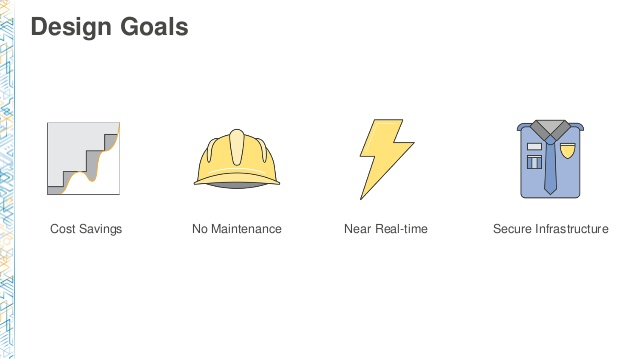

Coursera had a large monolithic application for processing batch jobs that was difficult to run, deploy, and scale

* A new thread was created for each job,  taking up different amounts of memory and CPU - inefficient
* No resource isolation allowed memory-limit errors to bring down the entire application.

The first logical step was to move to a microservices architecture using **Docker containers**, which needed **Kubernetes** for container orchestration. This was initially designed for the **GCE Platform**.

Utilizing Kubernetes required very experienced developers and coordination was difficult.

In 2013, Coursera decided to go with **AWS** when they introduced the **EC2 Container services**. 

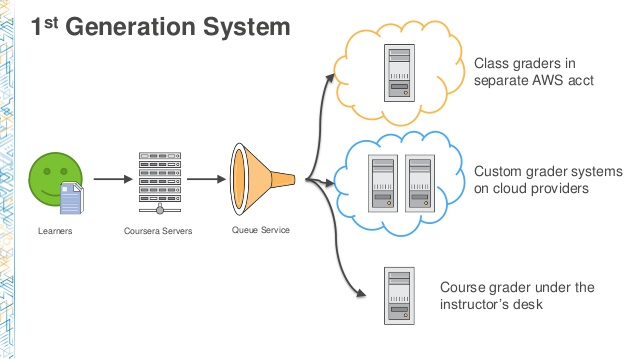

The advantages AWS offered were:

* Low maintenance
* Well integrated with the other AWS services, useful for scaling
* Easy for Coursera developers to use, as the deployment as that was taken care of by the AWS team.
* Cost-efficient Services, with pay-for-use model for services

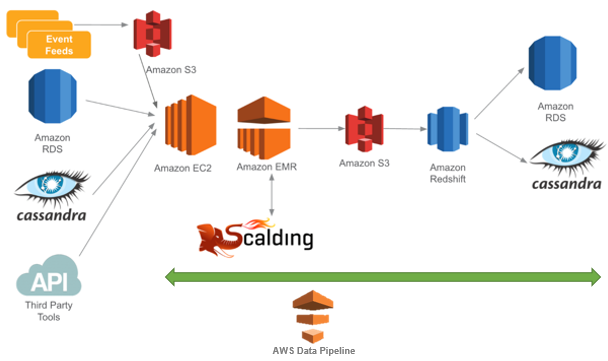

To work with AWS and the ECS Service, Coursera developed a few tools and intrnal frameworks of their own.

## <font color='blue'> The Iguazu Framework </font>

**Iguazu** is a **batch-processing framework** developed by Coursera for efficient and reliable batch processing. 

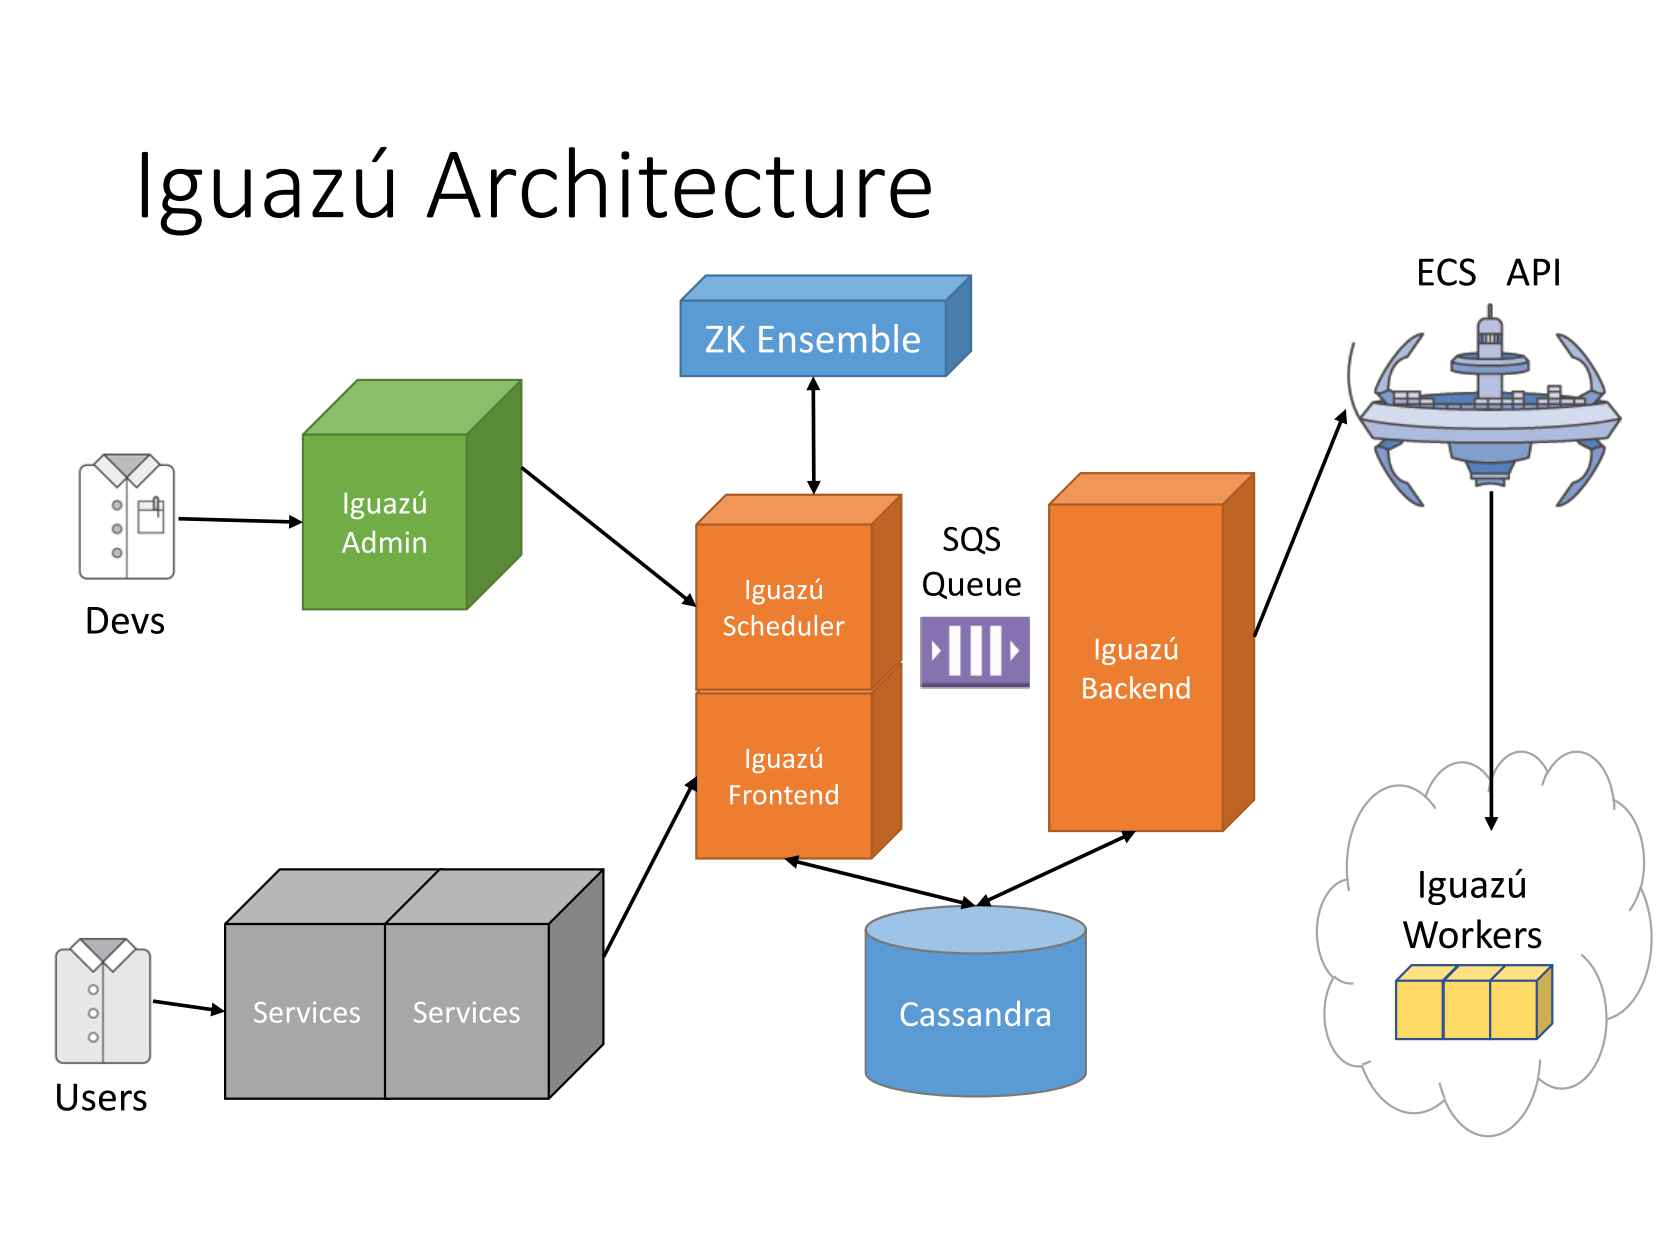

This architecture allowed Coursera developers to seamlessly push code to the cloud and with the help of Jenkins, which has excellent integration with AWS.

## <font color='blue'> Logs </font>

* AWS has easily accessible logs within the instance in the container folder.
* Logs can be uploaded for analysis
* Debugging, Searching, and Troubleshooting tools

## <font color='blue'> The Programming Grader Challenge </font>

Coursera needs to provide close to immediate results of the code snippets that are uploaded.

The evaluation methods are set up by the instructors in collaboration with Coursera which can be static test cases or bug detections.

The major challenges the grader faces are:

* Code can have infinite loops, and might consume resources or crash containers.
* Code comes in from thousands of students, which is untrusted and insecure, which can wreck EC2 systems and crash Coursera servers.

In addition, submitted code could introduce the following security vulnerabilities:

* Impact other grade submissions
* Disrupt the grading environment
* Change own scores, among others

## <font color='blue'> The GrID Architecture </font>

Coursera built the **GrID System** which sits on top of an **EC2 instance** and the **Iguazu framework**. 

It was built specifically for running, testing and grading the code submissions by the students and running test scripts by the instructors as well.

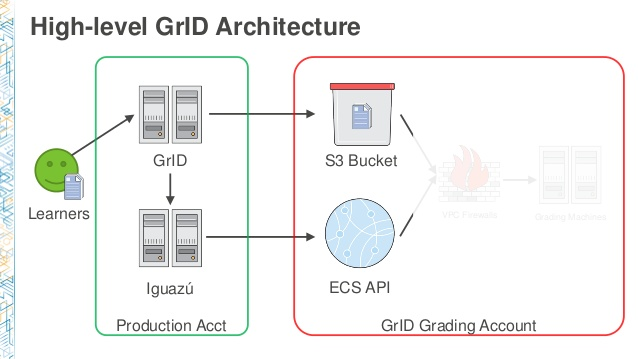

The GrID system provies the following advantages:

* Separates the grading system from the rest of the services
* CPU Quotas keep a check on malicious and unintentional long-running codes.
* Memory and Swap limits are put on each container as well.
* Timeouts for each docker container as a hard measure.
* Firewall prevented any possibility of hacks 
* Modifies instructor containers before they are run, and does not allow root users in Docker
* At the end of the day, all running EC2 instances of grading are terminated and restarted, to keep a check in dormant use of resources.

With the pandemic forcing students to study remotely, Coursera have been able to offer them an ideal platform, and instructors with a wider reach.

With this surge of users, Coursera was able to maintain it’s performance, and could keep introducing new features without any major downtime.

## <font color='blue'> References </font>

1. AWS Coursera Case Study: AWS Solutions - [https://aws.amazon.com/solutions/case-studies/coursera-ecs/](https://aws.amazon.com/solutions/case-studies/coursera-ecs/)
2. Amazon ECS At Coursera: A general purpose microservice - [https://www.slideshare.net/AmazonWebServices/cmp406-amazon-ecs-at-coursera-a-generalpurpose-microservice](https://www.slideshare.net/AmazonWebServices/cmp406-amazon-ecs-at-coursera-a-generalpurpose-microservice)
3. How AWS is helping empower Coursera to up-skill learners around the world? : Medium - [https://techboutique-official.medium.com/coursera-aws-success-story-ae6617bea87f](https://techboutique-official.medium.com/coursera-aws-success-story-ae6617bea87f)
4. Image: Coursera AWS First Generation System - [https://image.slidesharecdn.com/cmp406-151009004005-lva1-app6891/95/cmp406-amazon-ecs-at-coursera-a-generalpurpose-microservice-49-638.jpg?cb=1466115290](https://image.slidesharecdn.com/cmp406-151009004005-lva1-app6891/95/cmp406-amazon-ecs-at-coursera-a-generalpurpose-microservice-49-638.jpg?cb=1466115290)
5. Image: Coursera AWS Case Study Architecture - [https://media-exp1.licdn.com/dms/image/C4E12AQEHCIUA_Yw8KQ/article-inline_image-shrink_1000_1488/0/1600782030964?e=1622678400&v=beta&t=0OGHaTFKIfDscqmDDlmMsTyuY0196skbvE2RxhbfYZ8](https://media-exp1.licdn.com/dms/image/C4E12AQEHCIUA_Yw8KQ/article-inline_image-shrink_1000_1488/0/1600782030964?e=1622678400&v=beta&t=0OGHaTFKIfDscqmDDlmMsTyuY0196skbvE2RxhbfYZ8)
6. Image: Coursera Iguazu Architecture - [https://res.infoq.com/presentations/scala-ecs-docker-coursera/en/slides/sl32.jpg](https://res.infoq.com/presentations/scala-ecs-docker-coursera/en/slides/sl32.jpg)
7. Image: Coursera High Level GrID Architecture - [https://image.slidesharecdn.com/cmp406-151009004005-lva1-app6891/95/cmp406-amazon-ecs-at-coursera-a-generalpurpose-microservice-63-638.jpg?cb=1466115290](https://image.slidesharecdn.com/cmp406-151009004005-lva1-app6891/95/cmp406-amazon-ecs-at-coursera-a-generalpurpose-microservice-63-638.jpg?cb=1466115290)
8. Image: Coursera Architecture - Design Goals - [https://image.slidesharecdn.com/cmp406-151009004005-lva1-app6891/95/cmp406-amazon-ecs-at-coursera-a-generalpurpose-microservice-56-638.jpg?cb=1466115290](https://image.slidesharecdn.com/cmp406-151009004005-lva1-app6891/95/cmp406-amazon-ecs-at-coursera-a-generalpurpose-microservice-56-638.jpg?cb=1466115290)